In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import powerlaw
import matplotlib.lines as mlines
from scipy import signal
import seaborn as sns
from scipy.stats import entropy

%matplotlib inline

In [2]:
import json
import gzip
import datetime
import itertools

In [3]:
import networkx as nx

In [4]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

In [5]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [7]:
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 3
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17

width = 7
height = width / 1.618

matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['text.latex.unicode']=True

# Loading and preparing the data

Data taken from Reddit:
https://www.reddit.com/r/datasets/comments/9939fq/shopify_app_marketplace_dataset_2505_apps_253495/

In [8]:
f = gzip.open('./apps.json.gz')
data = json.load(f)
df = pd.io.json.json_normalize(data)
reviews = pd.io.json.json_normalize(df.reviews.values[0])

In [9]:
reviews_df = pd.concat([pd.io.json.json_normalize(sr.reviews).assign(app_name=sr['name']) for ix,sr in df.iterrows()], axis=0, sort=True)
reviews_df['stars'] = reviews_df.stars.astype(np.int64)
reviews_df['timetz'] = pd.to_datetime(reviews_df.published_at, cache=True)
reviews_df['time'] = pd.to_datetime(reviews_df.published_at.apply(lambda y: y[:-6]), cache=True)
reviews_df['reviewLen'] = reviews_df.content.apply(len)

In [10]:
reviews_df.stars.agg(['mean','median','std','skew'])

mean      4.738425
median    5.000000
std       0.794590
skew     -3.596463
Name: stars, dtype: float64

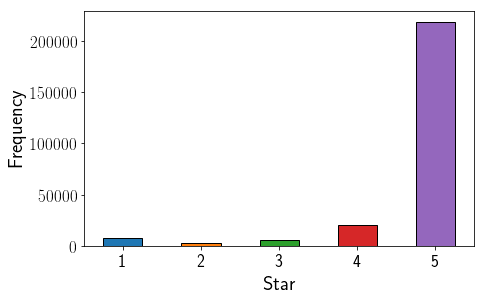

In [49]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df.groupby('stars').timetz.count().plot.bar(ax=ax, edgecolor='k', rot=0)

ax.set_xlabel('Star')
ax.set_ylabel('Frequency');

In [12]:
reviews_df.content.apply(len).quantile(0.99)

915.0

Text(0,0.5,'PDF')

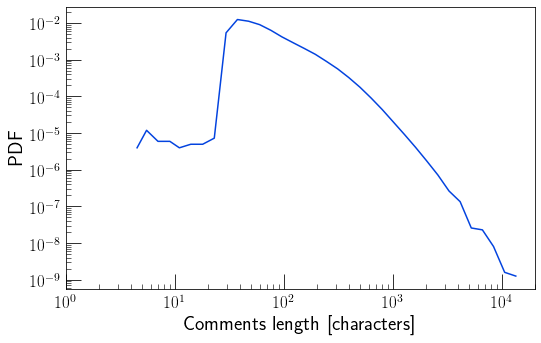

In [13]:
fig,ax = plt.subplots(figsize=(1.2*width, 1.2*height))

powerlaw.plot_pdf(reviews_df[reviews_df.content.apply(len)!=0].content.apply(len), ax=ax,
                  color='xkcd:blue', linewidth=1.5)

ax.tick_params(axis='both', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='both', which='minor', pad=1, length=5, direction='in')

ax.set_xlim(1e0, 2e4)

ax.set_xlabel('Comments length [characters]')
ax.set_ylabel('PDF')

In [14]:
contentlen_plf = powerlaw.Fit(reviews_df[reviews_df.content.apply(len)!=0].content.apply(len),
                              xmin=40, xmax=12000)

/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [15]:
contentlen_plf.supported_distributions

{'power_law': powerlaw.Power_Law,
 'lognormal': powerlaw.Lognormal,
 'exponential': powerlaw.Exponential,
 'truncated_power_law': powerlaw.Truncated_Power_Law,
 'stretched_exponential': powerlaw.Stretched_Exponential,
 'lognormal_positive': powerlaw.Lognormal_Positive}

/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


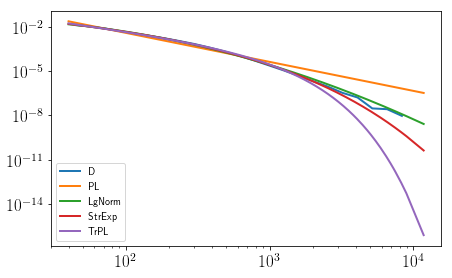

In [16]:
fig,ax = plt.subplots(figsize=(width, height))


contentlen_plf.plot_pdf(ax=ax, label='D')
contentlen_plf.power_law.plot_pdf(ax=ax, label='PL')
contentlen_plf.lognormal_positive.plot_pdf(ax=ax, label='LgNorm')
contentlen_plf.stretched_exponential.plot_pdf(ax=ax, label='StrExp')
contentlen_plf.truncated_power_law.plot_pdf(ax=ax, label='TrPL')

ax.legend()

In [17]:
print(contentlen_plf.nested_distribution_compare('power_law', 'lognormal_positive'))
print(contentlen_plf.nested_distribution_compare('truncated_power_law', 'lognormal_positive'))
print(contentlen_plf.nested_distribution_compare('exponential', 'lognormal_positive'))

print(contentlen_plf.nested_distribution_compare('stretched_exponential', 'lognormal_positive'))

print(contentlen_plf.nested_distribution_compare('power_law', 'stretched_exponential'))
print(contentlen_plf.nested_distribution_compare('truncated_power_law', 'stretched_exponential'))
print(contentlen_plf.nested_distribution_compare('exponential', 'stretched_exponential'))

(-11349.62243464325, 0.0)
(-109.43237472541523, 0.0)


/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(-23307.03522042124, 0.0)
(297.0060498232826, 0.0)
(-11646.628484462331, 0.0)
(-406.43842455001146, 0.0)
(-23604.0412702215, 0.0)


Assuming nested distributions


### Stretched exponential is a good fit

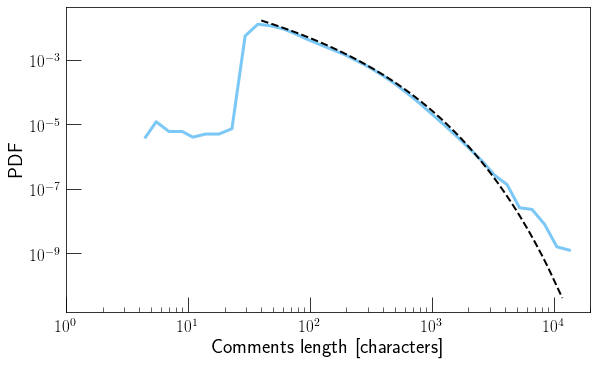

In [18]:
fig,ax = plt.subplots(figsize=(1.2*width, 1.2*height))

powerlaw.plot_pdf(reviews_df[reviews_df.content.apply(len)!=0].content.apply(len), ax=ax,
                  linewidth=3, color='xkcd:lightblue')

ax.tick_params(axis='both', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='both', which='minor', pad=1, length=5, direction='in')

contentlen_plf.stretched_exponential.plot_pdf(ax=ax, label='StrExp', linestyle='--',
                                              linewidth=2, color='k')

ax.set_xlim(1e0, 2e4)

ax.set_xlabel('Comments length [characters]')
ax.set_ylabel('PDF')

plt.tight_layout()

In [19]:
reviews_df.groupby('author_name').app_name.count().agg(['mean','median','std'])

mean      1.681191
median    1.000000
std       1.791838
Name: app_name, dtype: float64

In [20]:
reviews_df.groupby('author_name').app_name.count().rename('appName').to_frame()\
    .assign(r=lambda y: y.appName.rank(ascending=False))\
    .sort_values(by='r', ascending=False).r.max()

98388.0

Plot of rank vs. number of reviews (per user) seems to be a Power Law (***Zipf***), with the exception of the very first few authors.

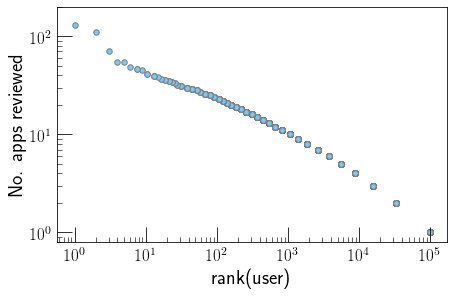

In [21]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df.groupby('author_name').app_name.count().rename('appName').to_frame()\
    .assign(r=lambda y: y.appName.rank(ascending=False))\
    .sort_values(by='r', ascending=False)\
    .plot.scatter('r', 'appName', ax=ax, c='xkcd:lightblue', edgecolor='grey', s=30)

ax.tick_params(axis='both', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='both', which='minor', pad=1, length=5, direction='in')

ax.set_ylabel('No. apps reviewed')
ax.set_xlabel('rank(user)')

ax.set_ylim(8e-1, 2e2)

ax.set_yscale('log')
ax.set_xscale('log')

# Review Length and Review Stars

In [22]:
reviews_df.assign(reviewLen=lambda y: y.content.apply(len))\
    .pipe(lambda y: y[y.stars < 4])[['stars', 'reviewLen']].corr(method='spearman')

stars  reviewLen
stars      1.000000  -0.220924
reviewLen -0.220924   1.000000

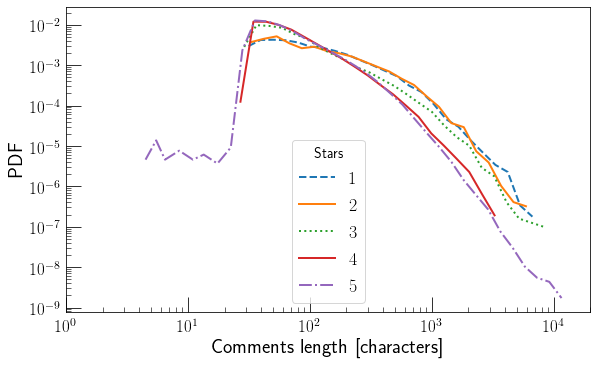

In [25]:
fig,ax = plt.subplots(figsize=(1.2*width, 1.2*height))

powerlaw.plot_pdf(reviews_df.assign(reviewLen=lambda y: y.content.apply(len))\
            .pipe(lambda y: y[(y.stars == 1)&(y.reviewLen>0)]).reviewLen, ax=ax,
                  label='$1$', linestyle='--')
powerlaw.plot_pdf(reviews_df.assign(reviewLen=lambda y: y.content.apply(len))\
            .pipe(lambda y: y[(y.stars == 2)&(y.reviewLen>0)]).reviewLen, ax=ax, label='$2$')
powerlaw.plot_pdf(reviews_df.assign(reviewLen=lambda y: y.content.apply(len))\
            .pipe(lambda y: y[(y.stars == 3)&(y.reviewLen>0)]).reviewLen, ax=ax,
                  label='$3$', linestyle=':')
powerlaw.plot_pdf(reviews_df.assign(reviewLen=lambda y: y.content.apply(len))\
            .pipe(lambda y: y[(y.stars == 4)&(y.reviewLen>0)]).reviewLen, ax=ax, label='$4$')
powerlaw.plot_pdf(reviews_df.assign(reviewLen=lambda y: y.content.apply(len))\
            .pipe(lambda y: y[(y.stars == 5)&(y.reviewLen>0)]).reviewLen, ax=ax,
                  label='$5$', linestyle='-.')
ax.tick_params(axis='both', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='both', which='minor', pad=1, length=5, direction='in')

ax.set_ylabel('PDF')
ax.set_xlabel('Comments length [characters]')
ax.set_xlim(1e0, 2e4)

L=ax.legend(fontsize=18, title='Stars')
L.get_title().set_fontsize(14)

plt.tight_layout()

In [26]:
ps_ = pd.cut(reviews_df.reviewLen, bins=np.linspace(1, 5000, num=25),
       labels=np.linspace(1, 5000, num=25)[:-1],
       retbins=True)

Probability distributions are different, and more improtantly, longer reviews (length of text) tend to be associated to lower stars (worse review).

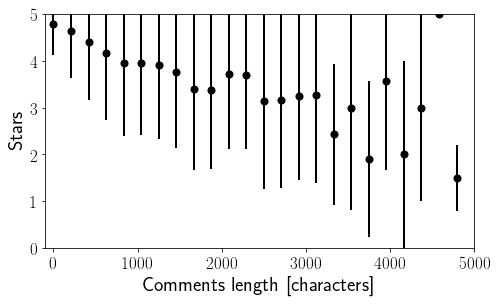

In [27]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df.groupby(ps_[0]).stars.agg(['mean','median','std']).dropna().reset_index()\
    .assign(revLen=lambda y: pd.to_numeric(y.reviewLen))\
    .plot.scatter('revLen', 'mean', yerr='std', ax=ax, s=50, c='k')

ax.set_ylim(0, 5)
ax.set_xlim(-100, 5000)
ax.set_ylabel('Stars')
ax.set_xlabel('Comments length [characters]')

plt.tight_layout()

# Time Series

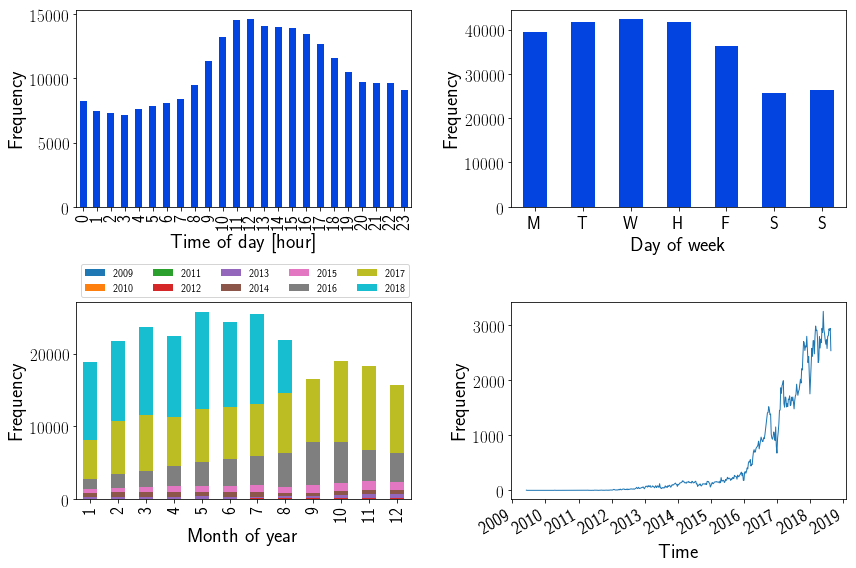

In [28]:
fig,axs = plt.subplots(2,2,figsize=(12, 8))

# Hours
reviews_df.groupby(reviews_df.time.dt.hour).content.count().plot.bar(color='xkcd:blue', ax=axs[0][0])
# Days of Week
reviews_df.groupby(reviews_df.time.dt.weekday).content.count().plot.bar(color='xkcd:blue', ax=axs[0][1], rot=0)
# Moth of year
reviews_df.groupby([reviews_df.time.dt.year, reviews_df.time.dt.month]).content.count().unstack(level=0)\
    .fillna(0).plot.bar(stacked=True, ax=axs[1][0])
# Weekly updates
reviews_df.groupby(reviews_df.timetz.dt.round('7D')).content.count().plot.line(ax=axs[1][1], linewidth=1)

axs[1][0].legend(bbox_to_anchor=(0., 1., 1., .202), loc=3, ncol=5, fontsize=10)

for axs_ in axs:
    for ax in axs_:
        ax.set_ylabel('Frequency')


axs[0][0].set_xlabel('Time of day [hour]')
axs[0][1].set_xlabel('Day of week')
axs[1][0].set_xlabel('Month of year')
axs[1][1].set_xlabel('Time')

axs[0][1].set_xticklabels(['M', 'T', 'W', 'H', 'F', 'S', 'S'])

plt.tight_layout()

(0, 5)

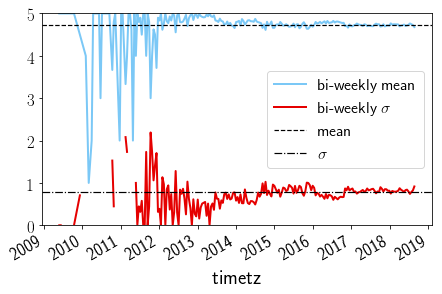

In [29]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df.groupby(reviews_df.timetz.dt.round('14D')).stars.mean().plot.line(ax=ax,
                                                                            label='bi-weekly mean',
                                                                            color='xkcd:lightblue')
reviews_df.groupby(reviews_df.timetz.dt.round('14D')).stars.std().plot.line(ax=ax,
                                                                           label=r'bi-weekly $\sigma$',
                                                                           color='xkcd:red')

ax.axhline(reviews_df.stars.mean(), c='k', linestyle='--', label='mean', linewidth=1.2)
ax.axhline(reviews_df.stars.std(),  c='k', linestyle='-.', label='$\sigma$', linewidth=1.2)

ax.legend(fontsize=16)
ax.set_ylim(0, 5)

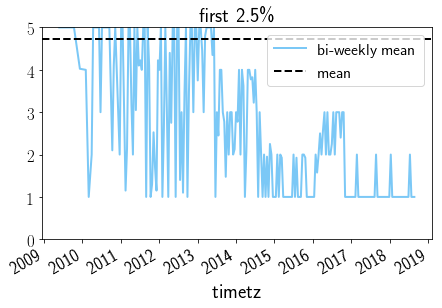

In [30]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df.groupby(reviews_df.timetz.dt.round('14D')).stars.quantile(0.025).plot.line(ax=ax,
                                                                            label='bi-weekly mean',
                                                                            color='xkcd:lightblue')

ax.axhline(reviews_df.stars.mean(), c='k', linestyle='--', label='mean')

ax.legend(fontsize=16)
ax.set_ylim(0, 5)
ax.set_title(r'first 2.5\%');

In [31]:
ps_ = pd.cut(reviews_df[reviews_df.reviewLen>0].timetz,
             bins=pd.date_range(start=datetime.datetime(2009,3,1), end=datetime.datetime(2019,1,2), freq='3MS'),
             labels=pd.date_range(start=datetime.datetime(2009,3,1), end=datetime.datetime(2019,1,2), freq='3MS')[:-1],
             retbins=True)

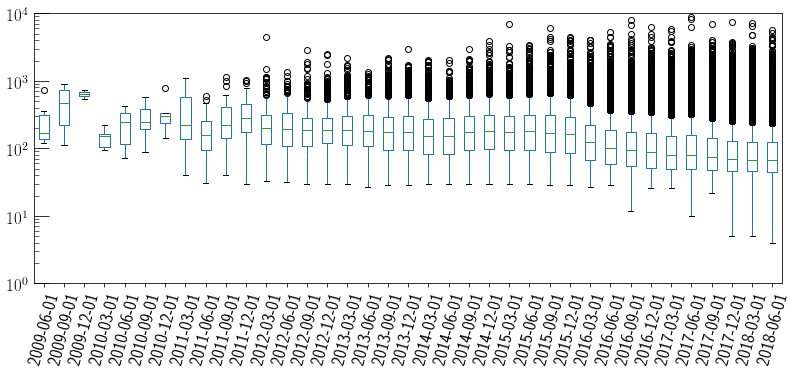

In [32]:
fig,ax = plt.subplots(figsize=(13, 5))

reviews_df[reviews_df.reviewLen>0].boxplot('reviewLen', by=pd.to_datetime(ps_[0]).dt.date, ax=ax, rot=75)

ax.set_yscale('log')

ax.set_xlabel('')
ax.set_title('')
plt.suptitle('')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_horizontalalignment('center')

ax.tick_params(axis='y', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='y', which='minor', pad=1, length=5, direction='in')

ax.set_ylim(1e0, 1e4)

ax.grid(False)

(0, 1200)

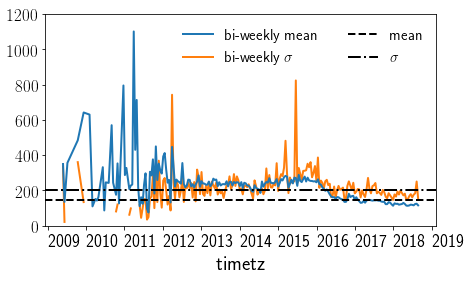

In [33]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df.groupby(reviews_df.timetz.dt.round('14D')).reviewLen.mean().plot.line(ax=ax, label=r'bi-weekly mean', zorder=1, rot=0)
reviews_df.groupby(reviews_df.timetz.dt.round('14D')).reviewLen.std().plot.line(ax=ax, label=r'bi-weekly $\sigma$', zorder=0, rot=0)

ax.axhline(reviews_df.reviewLen.mean(), c='k', linestyle='--', label='mean')
ax.axhline(reviews_df.reviewLen.std(),  c='k', linestyle='-.', label='$\sigma$')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_horizontalalignment('left')

ax.legend(fontsize=15, edgecolor='w', ncol=2)
ax.set_ylim(0, 1200)

In [34]:
reviews_df.sort_values('timetz', inplace=True)
reviews_df.reset_index(drop=True, inplace=True)

In [35]:
tdiff_plf = powerlaw.Fit(reviews_df.groupby('app_name').timetz.diff().dt.total_seconds().dropna().pipe(lambda y: y[y>0]),
                         xmin=900, xmax=2e4)

/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [36]:
print(tdiff_plf.nested_distribution_compare('power_law', 'lognormal_positive'))
print(tdiff_plf.nested_distribution_compare('truncated_power_law', 'lognormal_positive'))
print(tdiff_plf.nested_distribution_compare('exponential', 'lognormal_positive'))

print(tdiff_plf.nested_distribution_compare('stretched_exponential', 'lognormal_positive'))

print(tdiff_plf.nested_distribution_compare('power_law', 'stretched_exponential'))
print(tdiff_plf.nested_distribution_compare('truncated_power_law', 'stretched_exponential'))
print(tdiff_plf.nested_distribution_compare('exponential', 'stretched_exponential'))

/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(-34534.262725732704, 0.0)
(-8057.252273785303, 0.0)
(4240.617321289352, 0.0)
(4966.134799240256, 0.0)
(-39500.39752497345, 0.0)
(-13023.387073025595, 0.0)
(-725.5174779509277, 0.0)


Assuming nested distributions


None of these look actually ***good*** to me.

Text(0.5,0,'Time between reviews (per app) [seconds]')

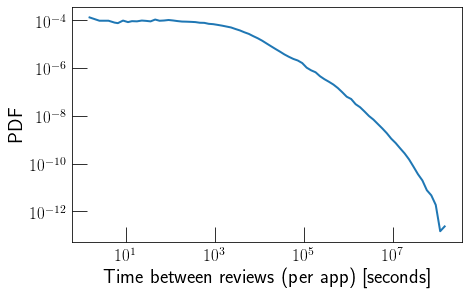

In [37]:
fig,ax = plt.subplots(figsize=(width, height))

#tdiff_plf.plot_pdf(ax=ax, c='xkcd:blue')
powerlaw.plot_pdf(reviews_df.groupby('app_name').timetz.diff().dt.total_seconds().dropna().pipe(lambda y: y[y>0]))
#tdiff_plf.exponential.plot_pdf(ax=ax, c='xkcd:purple', linestyle='--')

ax.tick_params(axis='both', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='both', which='minor', pad=1, length=5, direction='in')

ax.set_ylabel('PDF')
ax.set_xlabel('Time between reviews (per app) [seconds]')

In [38]:
tdiff_user_plf = powerlaw.Fit(reviews_df.groupby('author_name').timetz.diff().dt.total_seconds().dropna().pipe(lambda y: y[y>0]),
                         xmin=10, xmax=3e2)

/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [39]:
print(tdiff_user_plf.nested_distribution_compare('power_law', 'lognormal_positive'))
print(tdiff_user_plf.nested_distribution_compare('truncated_power_law', 'lognormal_positive'))
print(tdiff_user_plf.nested_distribution_compare('exponential', 'lognormal_positive'))

print(tdiff_user_plf.nested_distribution_compare('stretched_exponential', 'lognormal_positive'))

print(tdiff_user_plf.nested_distribution_compare('power_law', 'stretched_exponential'))
print(tdiff_user_plf.nested_distribution_compare('truncated_power_law', 'stretched_exponential'))
print(tdiff_user_plf.nested_distribution_compare('exponential', 'stretched_exponential'))

/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(-5653.057271587569, 0.0)
(-2476.6137224662248, 0.0)
(-143.87144705176203, 0.0)
(379.017678100807, 0.0)
(-6032.074949688374, 0.0)
(-2855.631400567048, 0.0)
(-522.8891251526035, 0.0)


Assuming nested distributions


In [40]:
data = reviews_df.groupby('author_name').timetz.diff().dt.total_seconds().dropna().pipe(lambda y: y[y>0]).values

In [41]:
np.max(data)

192068190.0

Interval between 10 seconds and 5 minutes is well described by a Lognormal distribution, which is typical of human behavior.

Text(0.5,0,'Time between reviews (per Username) [seconds]')

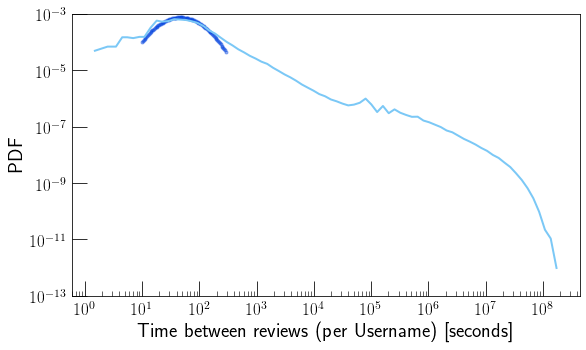

In [42]:
fig,ax = plt.subplots(figsize=(1.3*width, 1.2*height))

#tdiff_user_plf.plot_pdf(ax=ax, c='xkcd:blue')
powerlaw.plot_pdf(data, color='xkcd:lightblue')
#tdiff_user_plf.lognormal_positive.plot_pdf(ax=ax, c='xkcd:purple', linestyle='--')

ax.tick_params(axis='both', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='both', which='minor', pad=1, length=5, direction='in')

ax.scatter(np.logspace(np.log10(10), np.log10(300), num=100)[:-1],
           tdiff_user_plf.lognormal_positive.pdf(np.logspace(np.log10(10), np.log10(300),num=100))*9e-2,
           c='xkcd:blue', alpha=0.4)

ax.set_ylim(1e-13, 1e-3)

ax.set_ylabel('PDF')
ax.set_xlabel('Time between reviews (per Username) [seconds]')

In [43]:
tdiff_author_sr = reviews_df.groupby('author_name').timetz.diff().dt.total_seconds()
tdiff_app_sr    = reviews_df.groupby('app_name').timetz.diff().dt.total_seconds()

In [44]:
tdiff_author_log_sr = reviews_df[reviews_df.reviewLen>0].groupby('author_name').timetz.diff().dt.total_seconds()
tdiff_app_log_sr    = reviews_df[reviews_df.reviewLen>0].groupby('app_name').timetz.diff().dt.total_seconds()

In [45]:
t_step = 400
ps_ = pd.cut(tdiff_author_sr,
       bins=np.linspace(0, 30*86400, t_step), labels=[t+(t_step//2) for t in np.linspace(0, 30*86400, t_step)][:-1],
       retbins=True)

In [46]:
t_step = 400
ps_log_ = pd.cut(tdiff_author_log_sr,
         bins=np.linspace(0, 30*86400, t_step), labels=[t+(t_step//2) for t in np.linspace(0, 30*86400, t_step)][:-1],
         retbins=True)

Fundametaly, good reviews come in bursts, and bad reviews usually come after a longer period (and often have longer texts too).

(4, 5)

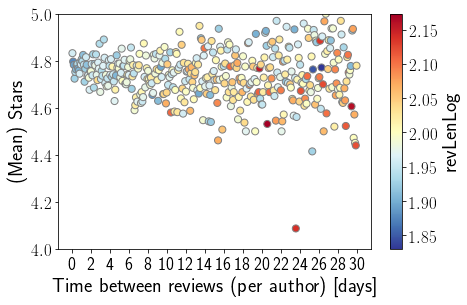

In [47]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df[reviews_df.reviewLen>0].assign(authortdiff=tdiff_author_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'mean', 'revLenLog':'mean'})\
    .reset_index().assign(authortdiff=lambda y: pd.to_numeric(y.timetz))\
    .plot.scatter('authortdiff', 'stars', c='revLenLog', cmap='RdYlBu_r',
                  s=50, ax=ax, edgecolor='grey')

ax.set_xlabel('Time between reviews (per author) [days]')
ax.set_ylabel('(Mean) Stars')

ax.set_xticks(range(0,31*86400, 2*86400))
ax.set_xticklabels(range(0,31,2))

ax.set_ylim(4, 5)

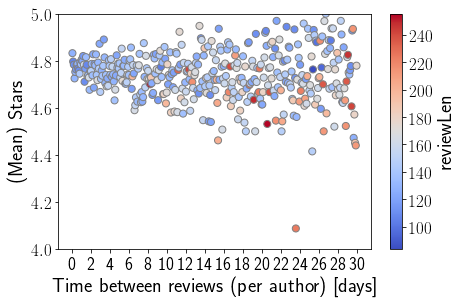

In [48]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df.assign(authortdiff=tdiff_author_sr)\
    .groupby(ps_[0]).agg({'stars':'mean', 'reviewLen':'mean'})\
    .reset_index().assign(authortdiff=lambda y: pd.to_numeric(y.timetz))\
    .plot.scatter('authortdiff', 'stars', c='reviewLen', cmap='coolwarm',
                  s=50, ax=ax, edgecolor='grey')

ax.set_xlabel('Time between reviews (per author) [days]')
ax.set_ylabel('(Mean) Stars')

ax.set_xticks(range(0,31*86400, 2*86400))
ax.set_xticklabels(range(0,31,2))

ax.set_ylim(4, 5);

In [50]:
reviews_df[reviews_df.reviewLen>0].assign(authortdiff=tdiff_author_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'mean', 'revLenLog':'mean'})\
    .reset_index().assign(authortdiff=lambda y: pd.to_numeric(y.timetz)).corr()

stars  revLenLog  authortdiff
stars        1.000000  -0.254519    -0.070334
revLenLog   -0.254519   1.000000     0.382562
authortdiff -0.070334   0.382562     1.000000

In [51]:
reviews_df[reviews_df.reviewLen>0].assign(authortdiff=tdiff_author_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'mean', 'revLenLog':'mean'})\
    .reset_index().assign(authortdiff=lambda y: pd.to_numeric(y.timetz)).corr(method='spearman')

stars  revLenLog  authortdiff
stars        1.000000  -0.237304    -0.074092
revLenLog   -0.237304   1.000000     0.382848
authortdiff -0.074092   0.382848     1.000000

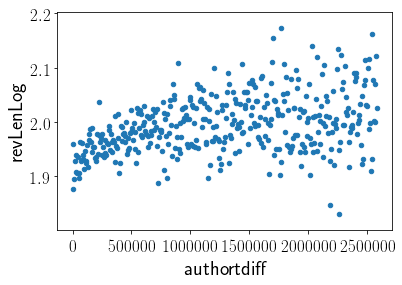

In [52]:
reviews_df[reviews_df.reviewLen>0].assign(authortdiff=tdiff_author_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'mean', 'revLenLog':'mean'})\
    .reset_index().assign(authortdiff=lambda y: pd.to_numeric(y.timetz))\
    .plot.scatter('authortdiff', 'revLenLog')

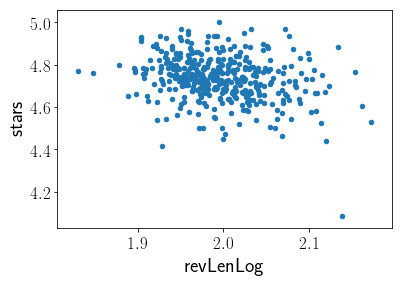

In [53]:
reviews_df[reviews_df.reviewLen>0].assign(authortdiff=tdiff_author_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'mean', 'revLenLog':'mean'})\
    .reset_index().assign(authortdiff=lambda y: pd.to_numeric(y.timetz))\
    .plot.scatter('revLenLog', 'stars')

In [54]:
t_step = 400
ps_ = pd.cut(tdiff_app_sr,
       bins=np.linspace(0, 30*86400, t_step), labels=[t+(t_step//2) for t in np.linspace(0, 30*86400, t_step)][:-1],
       retbins=True)

In [55]:
t_step = 400
ps_log_ = pd.cut(tdiff_app_log_sr,
         bins=np.linspace(0, 30*86400, t_step), labels=[t+(t_step//2) for t in np.linspace(0, 30*86400, t_step)][:-1],
         retbins=True)

Per app, something similar happens: *good* reviews come in bursts and *worse* reviews come after longer periods of time (and are also longer in size). Same for reviews standard deviation, all supported by high correlation coefficients.

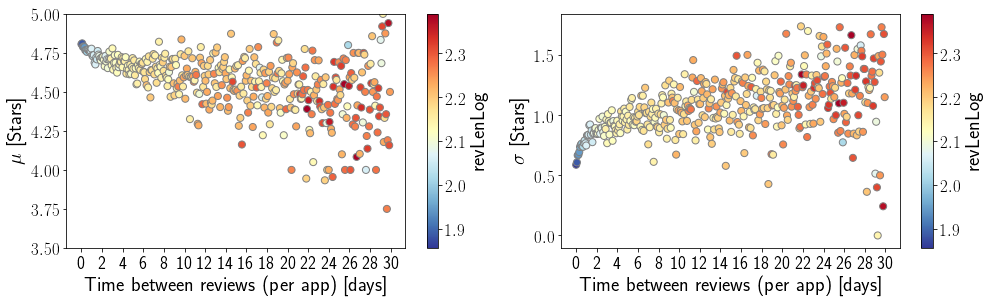

In [59]:
fig,axs = plt.subplots(1,2,figsize=(2*width, height))

reviews_df[reviews_df.reviewLen>0].assign(apptdiff=tdiff_app_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'mean', 'revLenLog':'mean'})\
    .reset_index().assign(apptdiff=lambda y: pd.to_numeric(y.timetz))\
    .plot.scatter('apptdiff', 'stars', c='revLenLog', cmap='RdYlBu_r',
                  s=50, ax=axs[0], edgecolor='grey')

axs[0].set_xlabel('Time between reviews (per app) [days]')
axs[0].set_ylabel('$\mu$ [Stars]')

axs[0].set_ylim(3.5, 5)

reviews_df[reviews_df.reviewLen>0].assign(apptdiff=tdiff_app_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'std', 'revLenLog':'mean'})\
    .reset_index().assign(apptdiff=lambda y: pd.to_numeric(y.timetz))\
    .plot.scatter('apptdiff', 'stars', c='revLenLog', cmap='RdYlBu_r',
                  s=50, ax=axs[1], edgecolor='grey')

axs[1].set_xlabel('Time between reviews (per app) [days]')
axs[1].set_ylabel('$\sigma$ [Stars]')

#axs[1].set_ylim(4.4, 5)
for ax in axs:
    ax.set_xticks(range(0,31*86400, 2*86400))
    ax.set_xticklabels(range(0,31,2))

plt.tight_layout()

In [60]:
reviews_df[reviews_df.reviewLen>0].assign(apptdiff=tdiff_app_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'mean', 'revLenLog':'mean'})\
    .reset_index().assign(apptdiff=lambda y: pd.to_numeric(y.timetz)).corr()

stars  revLenLog  apptdiff
stars      1.000000  -0.385036 -0.487104
revLenLog -0.385036   1.000000  0.649086
apptdiff  -0.487104   0.649086  1.000000

In [61]:
reviews_df[reviews_df.reviewLen>0].assign(apptdiff=tdiff_app_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'mean', 'revLenLog':'mean'})\
    .reset_index().assign(apptdiff=lambda y: pd.to_numeric(y.timetz)).corr(method='spearman')

stars  revLenLog  apptdiff
stars      1.000000  -0.430851 -0.509177
revLenLog -0.430851   1.000000  0.650525
apptdiff  -0.509177   0.650525  1.000000

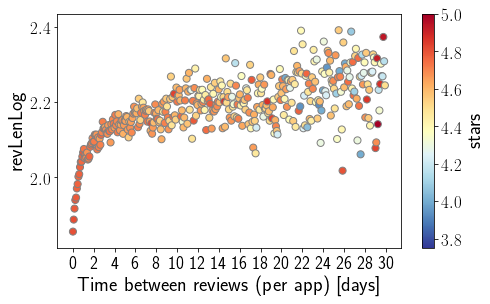

In [62]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df[reviews_df.reviewLen>0].assign(apptdiff=tdiff_app_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'mean', 'revLenLog':'mean', 'reviewLen':'mean'})\
    .reset_index().assign(apptdiff=lambda y: pd.to_numeric(y.timetz))\
    .plot.scatter('apptdiff', 'revLenLog', c='stars', cmap='RdYlBu_r',
                  s=50, edgecolor='grey', ax=ax)

ax.set_xticks(range(0,31*86400, 2*86400))
ax.set_xticklabels(range(0,31,2))

ax.set_xlabel('Time between reviews (per app) [days]')

plt.tight_layout()

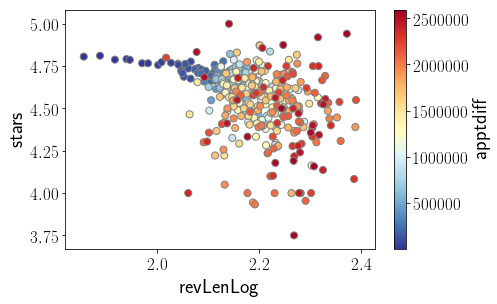

In [63]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df[reviews_df.reviewLen>0].assign(apptdiff=tdiff_app_sr)\
    .assign(revLenLog=lambda y: np.log10(y.reviewLen))\
    .groupby(ps_log_[0]).agg({'stars':'mean', 'revLenLog':'mean'})\
    .reset_index().assign(apptdiff=lambda y: pd.to_numeric(y.timetz))\
    .plot.scatter('revLenLog', 'stars', c='apptdiff',
                  edgecolor='grey', cmap='RdYlBu_r', s=50, ax=ax)

plt.tight_layout()

In [64]:
reviews_df.app_name.nunique()

2145

In [65]:
no_revs_plf = powerlaw.Fit(reviews_df.groupby('app_name').timetz.count(),
                           xmin=1, xmax=1e4)

/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [66]:
print(no_revs_plf.nested_distribution_compare('power_law', 'lognormal_positive'))
print(no_revs_plf.nested_distribution_compare('truncated_power_law', 'lognormal_positive'))
print(no_revs_plf.nested_distribution_compare('exponential', 'lognormal_positive'))

print(no_revs_plf.nested_distribution_compare('stretched_exponential', 'lognormal_positive'))

print(no_revs_plf.nested_distribution_compare('power_law', 'stretched_exponential'))
print(no_revs_plf.nested_distribution_compare('truncated_power_law', 'stretched_exponential'))
print(no_revs_plf.nested_distribution_compare('exponential', 'stretched_exponential'))

/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(-150.24160405754228, 0.0)
(13.451766438065468, 2.1386758841668296e-07)
(-2379.2579903907713, 0.0)
(15.896874405169081, 1.7144364927723643e-08)
(-166.13847846270804, 0.0)
(-2.44510796710696, 0.027009307888285594)
(-2395.1548647959535, 0.0)


/home/tonetto/miniconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Assuming nested distributions


Text(0.5,0,'No. reviews (per app)')

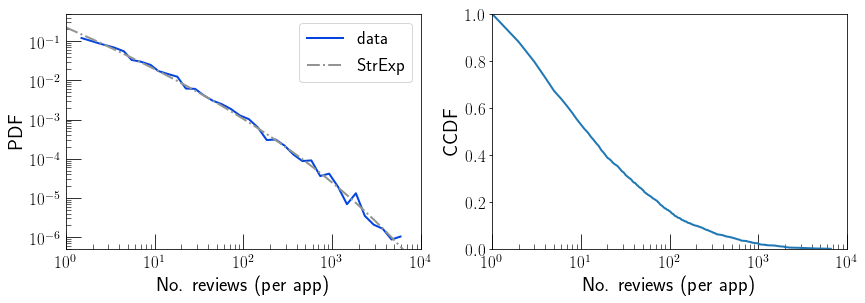

In [67]:
fig,axs = plt.subplots(1,2,figsize=(2*width, height))

# powerlaw.plot_pdf(reviews_df.groupby('app_name').timetz.count(),
#                   ax=ax, c='xkcd:blue')

no_revs_plf.plot_pdf(ax=axs[0], c='xkcd:blue', linestyle='-', label='data')
no_revs_plf.stretched_exponential.plot_pdf(ax=axs[0], color='xkcd:grey', linestyle='-.', label='StrExp')
axs[0].set_xlim(1e0, 1e4)
axs[0].set_ylim(5e-7, 5e-1)
axs[0].tick_params(axis='both', which='major', pad=5, length=15, direction='in')
axs[0].tick_params(axis='both', which='minor', pad=1, length=5, direction='in')
axs[0].legend(fontsize=18, markerscale=2)
axs[0].set_ylabel('PDF')
axs[0].set_xlabel('No. reviews (per app)')

no_revs_plf.plot_ccdf(ax=axs[1])
axs[1].set_yscale('linear')
axs[1].tick_params(axis='x', which='major', pad=5, length=15, direction='in')
axs[1].tick_params(axis='x', which='minor', pad=1, length=5, direction='in')
axs[1].set_ylim(0, 1)
axs[1].set_xlim(1e0, 1e4)
axs[1].set_ylabel('CCDF')
axs[1].set_xlabel('No. reviews (per app)')

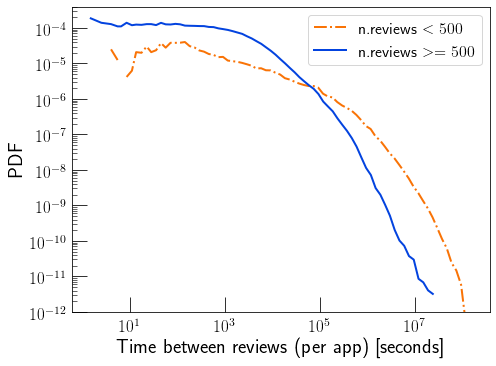

In [68]:
fig,ax = plt.subplots(figsize=(width, 1.2*height))

#tdiff_plf.plot_pdf(ax=ax, c='xkcd:blue')
#powerlaw.plot_pdf(reviews_df.groupby('app_name').timetz.diff().dt.seconds.dropna().pipe(lambda y: y[y>0]))
powerlaw.plot_pdf(reviews_df.groupby('app_name').filter(lambda x: x.timetz.count()< 500).groupby('app_name').timetz.diff().dt.total_seconds().dropna().pipe(lambda y: y[y>0]),
                  label=r'n.reviews $< 500$', color='xkcd:orange', linestyle='-.')
powerlaw.plot_pdf(reviews_df.groupby('app_name').filter(lambda x: x.timetz.count()>=500).groupby('app_name').timetz.diff().dt.total_seconds().dropna().pipe(lambda y: y[y>0]),
                  label=r'n.reviews $>= 500$', color='xkcd:blue', linestyle='-')

ax.legend(fontsize=16)

ax.tick_params(axis='both', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='both', which='minor', pad=1, length=5, direction='in')

ax.set_ylim(1e-12, 4e-4)

ax.set_ylabel('PDF')
ax.set_xlabel('Time between reviews (per app) [seconds]')

plt.tight_layout()

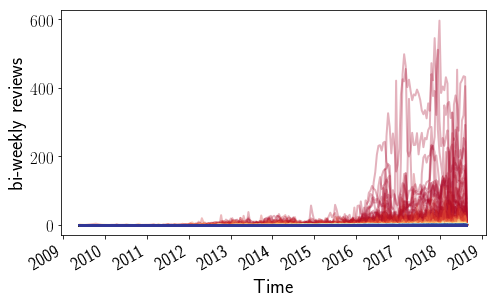

In [72]:
fig,ax = plt.subplots(figsize=(width, height))

reviews_df.rename(columns={'app_name':'appName'})\
    .groupby(['appName',
                    reviews_df.timetz.dt.round('14D')]).timetz.count()\
    .unstack(level=0).fillna(0)\
    .reindex(columns=reviews_df.groupby('app_name').timetz.count().sort_values(ascending=False).index)\
    .plot.line(ax=ax, cmap='RdYlBu', alpha=0.3)

ax.legend().remove()
ax.set_xlabel('Time')
ax.set_ylabel('bi-weekly reviews')

plt.tight_layout()

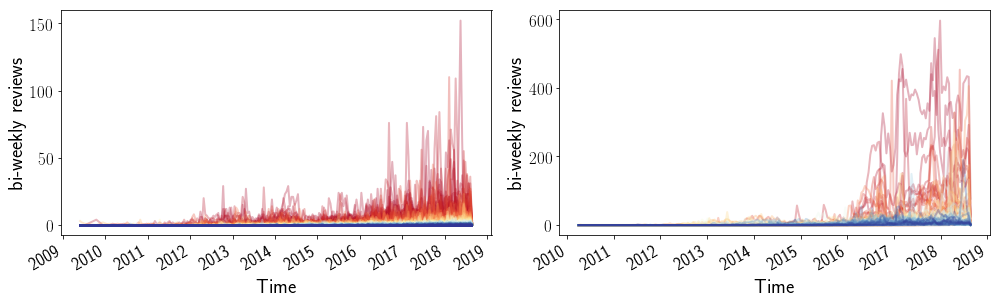

In [70]:
fig,axs = plt.subplots(1,2,figsize=(2*width, height))

reviews_df.groupby('app_name').filter(lambda y: y.timetz.count()<=500)\
    .rename(columns={'app_name':'appName'})\
    .groupby(['appName', reviews_df.timetz.dt.round('14D')]).timetz.count()\
    .unstack(level=0).fillna(0)\
    .reindex(columns=reviews_df.groupby('app_name').filter(lambda y: y.timetz.count()<=500)\
                 .groupby('app_name').timetz.count().sort_values(ascending=False).index)\
    .plot.line(ax=axs[0], cmap='RdYlBu', alpha=0.3)

axs[0].legend().remove()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('bi-weekly reviews')

reviews_df.groupby('app_name').filter(lambda y: y.timetz.count()>500)\
    .rename(columns={'app_name':'appName'})\
    .groupby(['appName', reviews_df.timetz.dt.round('14D')]).timetz.count()\
    .unstack(level=0).fillna(0)\
    .reindex(columns=reviews_df.groupby('app_name').filter(lambda y: y.timetz.count()>500)\
                         .groupby('app_name').timetz.count().sort_values(ascending=False).index)\
    .fillna(0)\
    .plot.line(ax=axs[1], cmap='RdYlBu', alpha=0.3)

axs[1].legend().remove()
axs[1].set_xlabel('Time')
axs[1].set_ylabel('bi-weekly reviews')

plt.tight_layout()

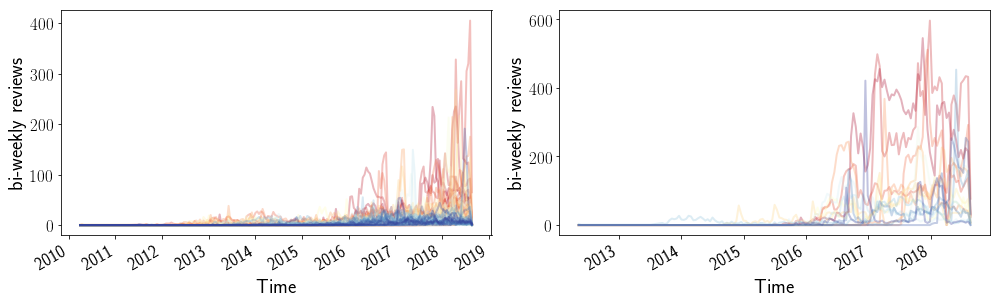

In [71]:
fig,axs = plt.subplots(1,2,figsize=(2*width, height))

reviews_df.groupby('app_name').filter(lambda y: (y.timetz.count()>500)&(y.timetz.count()<2000))\
    .rename(columns={'app_name':'appName'})\
    .groupby(['appName', reviews_df.timetz.dt.round('14D')]).timetz.count()\
    .unstack(level=0).fillna(0)\
    .reindex(columns=reviews_df.groupby('app_name').filter(lambda y: (y.timetz.count()>500)&(y.timetz.count()<2000))\
                 .groupby('app_name').timetz.count().sort_values(ascending=False).index)\
    .plot.line(ax=axs[0], cmap='RdYlBu', alpha=0.3)

axs[0].legend().remove()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('bi-weekly reviews')

reviews_df.groupby('app_name').filter(lambda y: y.timetz.count()>2000)\
    .rename(columns={'app_name':'appName'})\
    .groupby(['appName', reviews_df.timetz.dt.round('14D')]).timetz.count()\
    .unstack(level=0).fillna(0)\
    .reindex(columns=reviews_df.groupby('app_name').filter(lambda y: y.timetz.count()>2000)\
                 .groupby('app_name').timetz.count().sort_values(ascending=False).index)\
    .plot.line(ax=axs[1], cmap='RdYlBu', alpha=0.3)

axs[1].legend().remove()
axs[1].set_xlabel('Time')
axs[1].set_ylabel('bi-weekly reviews')

plt.tight_layout()

# Time Series Analysis

In [73]:
data = reviews_df.groupby('app_name').filter(lambda y: (y.timetz.count()<500)&(y.timetz.count()>15))\
    .rename(columns={'app_name':'appName'})\
    .groupby(['appName', reviews_df.timetz.dt.round('1D')]).timetz.count()\
    .unstack(level=0).fillna(0)\
    .reindex(columns=reviews_df.groupby('app_name').filter(lambda y: (y.timetz.count()<500)&(y.timetz.count()>15))\
                 .groupby('app_name').timetz.count().sort_values(ascending=True).index)

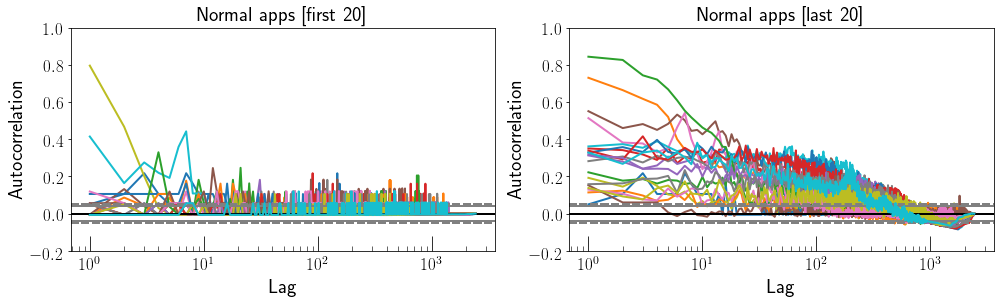

In [74]:
fig,axs = plt.subplots(1,2,figsize=(2*width, height))

for ix in range(20):
    autocorrelation_plot(data.iloc[:, [ix]], ax=axs[0])
axs[0].set_title('Normal apps [first 20]')

for ix in range(20):
    autocorrelation_plot(data.iloc[:, [-ix]], ax=axs[1])
axs[1].set_title('Normal apps [last 20]')

for ax in axs:
    ax.set_xscale('log')
    ax.set_ylim(-.2, 1.)
    ax.tick_params(axis='x', which='major', pad=5, length=15, direction='in')
    ax.tick_params(axis='x', which='minor', pad=1, length=5, direction='in')

plt.tight_layout()

In [75]:
data = reviews_df.groupby('app_name').filter(lambda y: (y.timetz.count()>500)&(y.timetz.count()<2000))\
    .rename(columns={'app_name':'appName'})\
    .groupby(['appName', reviews_df.timetz.dt.round('1D')]).timetz.count()\
    .unstack(level=0).fillna(0)\
    .reindex(columns=reviews_df.groupby('app_name').filter(lambda y: (y.timetz.count()>500)&(y.timetz.count()<2000))\
                 .groupby('app_name').timetz.count().sort_values(ascending=True).index)

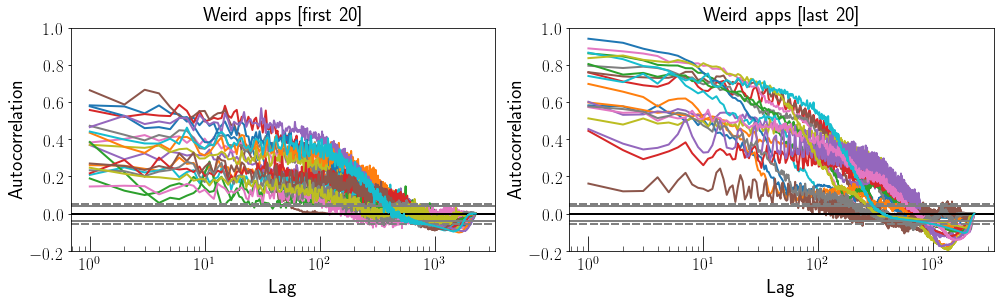

In [76]:
fig,axs = plt.subplots(1,2,figsize=(2*width, height))

for ix in range(20):
    autocorrelation_plot(data.iloc[:, [ix]], ax=axs[0])
axs[0].set_title('Weird apps [first 20]')
    
for ix in range(20):
    autocorrelation_plot(data.iloc[:, [-ix]], ax=axs[1])
axs[1].set_title('Weird apps [last 20]')

for ax in axs:
    ax.set_xscale('log')
    ax.set_ylim(-.2, 1.)
    ax.tick_params(axis='x', which='major', pad=5, length=15, direction='in')
    ax.tick_params(axis='x', which='minor', pad=1, length=5, direction='in')

plt.tight_layout()

Yes, the next was done manually... at least it worked pretty well to validate whatever I could see with the t-SNE clustering.

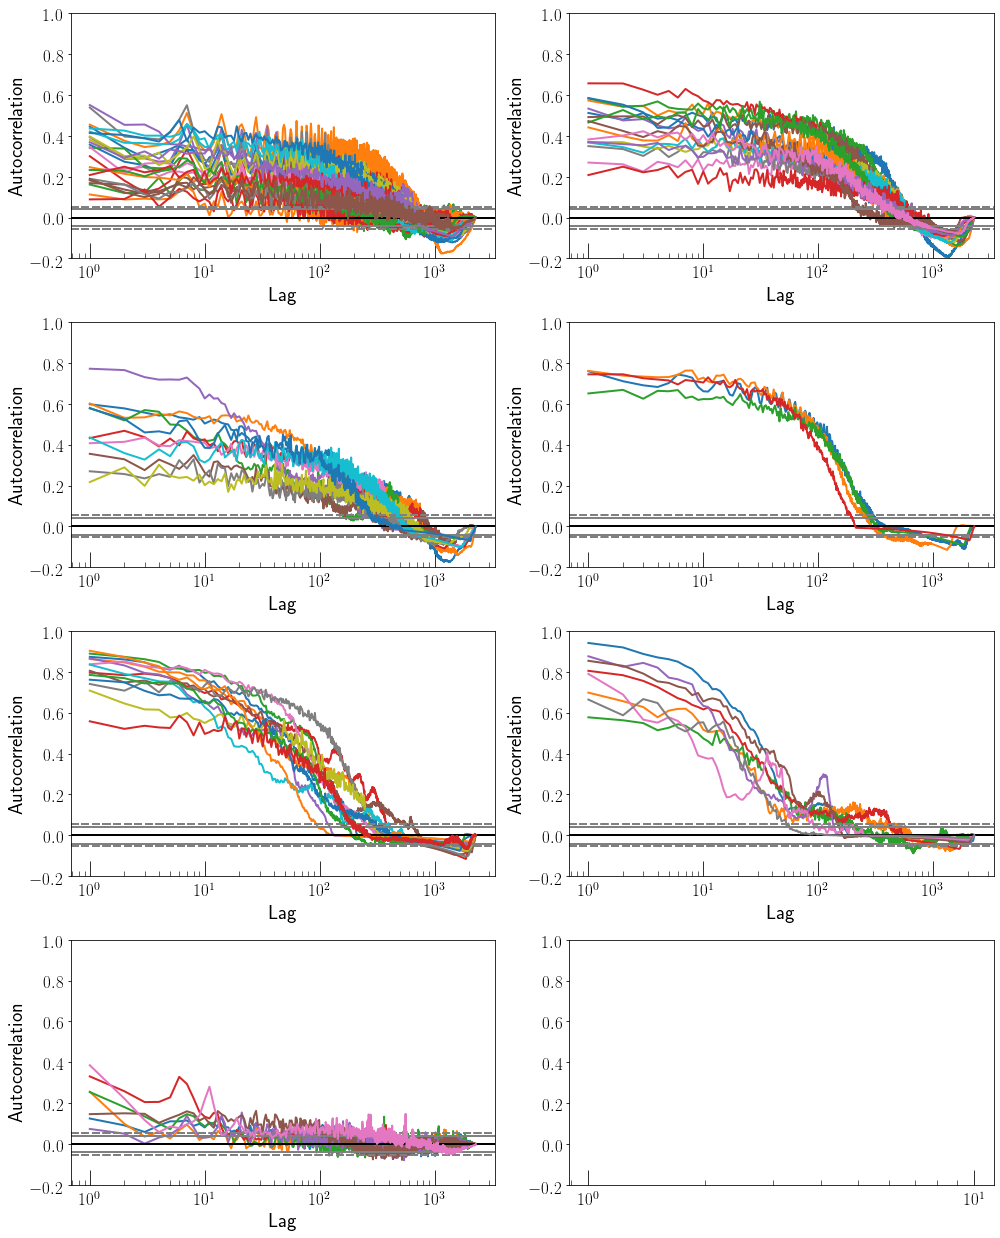

In [77]:
fig,axs = plt.subplots(4,2,figsize=(2*width, 4*height))

autocorrelation_plot(data.iloc[:, [-13]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-14]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-15]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-22]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-26]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-28]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-29]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-30]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-31]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-32]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-38]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-42]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-44]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-46]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-62]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-63]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-64]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-65]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-66]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-67]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-68]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-71]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-72]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-80]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-85]], ax=axs[0][0])
autocorrelation_plot(data.iloc[:, [-87]], ax=axs[0][0])

autocorrelation_plot(data.iloc[:, [-8]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-16]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-34]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-35]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-49]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-50]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-51]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-54]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-55]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-57]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-58]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-70]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-75]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-80]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-81]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-82]], ax=axs[0][1])
autocorrelation_plot(data.iloc[:, [-83]], ax=axs[0][1])

autocorrelation_plot(data.iloc[:, [-1]], ax=axs[1][0])
autocorrelation_plot(data.iloc[:, [-4]], ax=axs[1][0])
autocorrelation_plot(data.iloc[:, [-37]], ax=axs[1][0])
autocorrelation_plot(data.iloc[:, [-39]], ax=axs[1][0])
autocorrelation_plot(data.iloc[:, [-45]], ax=axs[1][0])
autocorrelation_plot(data.iloc[:, [-56]], ax=axs[1][0])
autocorrelation_plot(data.iloc[:, [-59]], ax=axs[1][0])
autocorrelation_plot(data.iloc[:, [-74]], ax=axs[1][0])
autocorrelation_plot(data.iloc[:, [-76]], ax=axs[1][0])
autocorrelation_plot(data.iloc[:, [-78]], ax=axs[1][0])
autocorrelation_plot(data.iloc[:, [-79]], ax=axs[1][0])

autocorrelation_plot(data.iloc[:, [-3]], ax=axs[1][1])
autocorrelation_plot(data.iloc[:, [-5]], ax=axs[1][1])
autocorrelation_plot(data.iloc[:, [-47]], ax=axs[1][1])
autocorrelation_plot(data.iloc[:, [-53]], ax=axs[1][1])

autocorrelation_plot(data.iloc[:, [-23]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-2]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-6]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-7]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-9]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-12]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-18]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-19]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-20]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-27]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-33]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-40]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-52]], ax=axs[2][0])
autocorrelation_plot(data.iloc[:, [-86]], ax=axs[2][0])

autocorrelation_plot(data.iloc[:, [-10]], ax=axs[2][1])
autocorrelation_plot(data.iloc[:, [-11]], ax=axs[2][1])
autocorrelation_plot(data.iloc[:, [-17]], ax=axs[2][1])
autocorrelation_plot(data.iloc[:, [-25]], ax=axs[2][1])
autocorrelation_plot(data.iloc[:, [-36]], ax=axs[2][1])
autocorrelation_plot(data.iloc[:, [-43]], ax=axs[2][1])
autocorrelation_plot(data.iloc[:, [-48]], ax=axs[2][1])
autocorrelation_plot(data.iloc[:, [-84]], ax=axs[2][1])

autocorrelation_plot(data.iloc[:, [-21]], ax=axs[3][0])
autocorrelation_plot(data.iloc[:, [-24]], ax=axs[3][0])
autocorrelation_plot(data.iloc[:, [-41]], ax=axs[3][0])
autocorrelation_plot(data.iloc[:, [-60]], ax=axs[3][0])
autocorrelation_plot(data.iloc[:, [-61]], ax=axs[3][0])
autocorrelation_plot(data.iloc[:, [-73]], ax=axs[3][0])
autocorrelation_plot(data.iloc[:, [-77]], ax=axs[3][0])



for axs_ in axs:
    for ax in axs_:
        ax.set_xscale('log')
        ax.set_ylim(-0.2, 1.)
        ax.tick_params(axis='x', which='major', pad=5, length=15, direction='in')
        ax.tick_params(axis='x', which='minor', pad=1, length=5, direction='in')
        ax.grid(False)

plt.tight_layout()

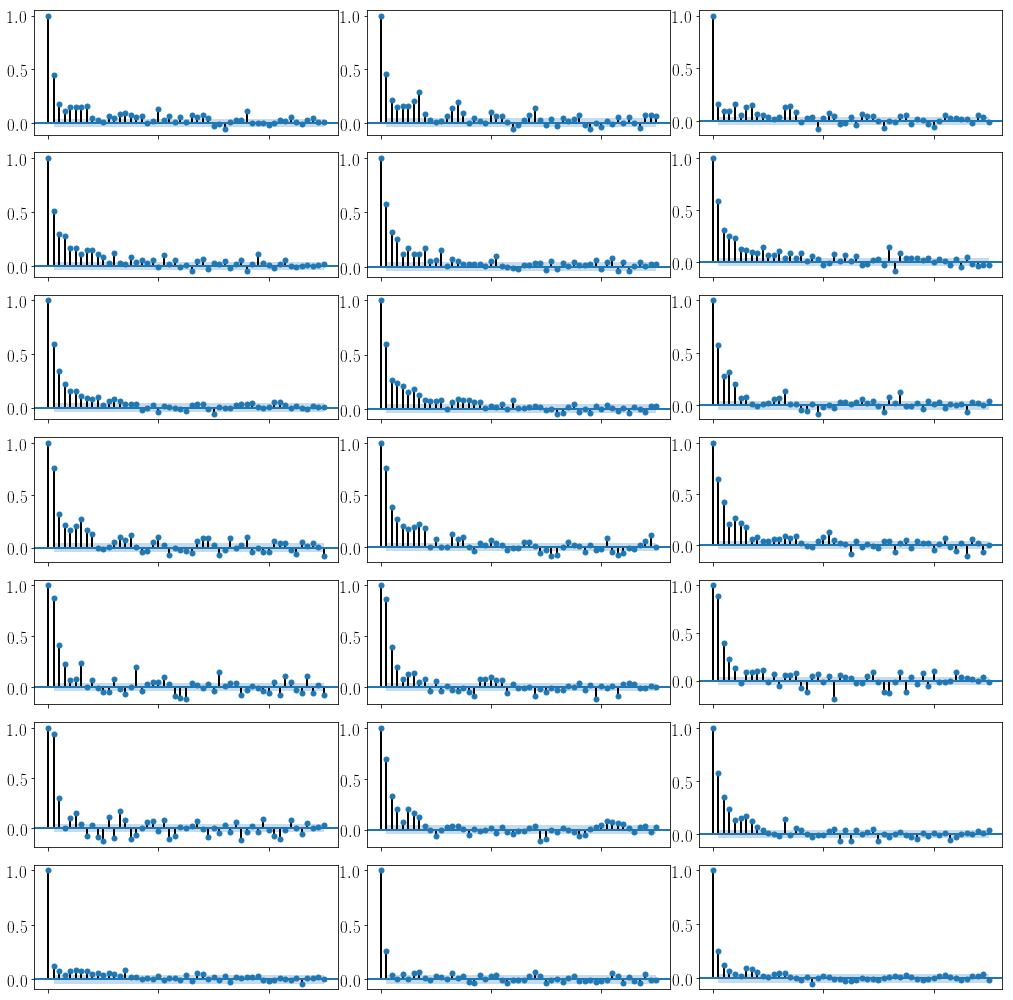

In [78]:
fig,axs = plt.subplots(7,3,figsize=(14, 14))

for ix,i in enumerate([13, 14, 15]):
    plot_pacf(data.iloc[:, [-i]], ax=axs[0][ix], lags=50)

for ix,i in enumerate([8, 16, 34]):
    plot_pacf(data.iloc[:, [-i]], ax=axs[1][ix], lags=50)

for ix,i in enumerate([1, 4, 37]):
    plot_pacf(data.iloc[:, [-i]], ax=axs[2][ix], lags=50)

for ix,i in enumerate([3, 5, 47]):
    plot_pacf(data.iloc[:, [-i]], ax=axs[3][ix], lags=50)

for ix,i in enumerate([23, 2, 6]):
    plot_pacf(data.iloc[:, [-i]], ax=axs[4][ix], lags=50)

for ix,i in enumerate([10, 11, 17]):
    plot_pacf(data.iloc[:, [-i]], ax=axs[5][ix], lags=50)

for ix,i in enumerate([21, 24, 41]):
    plot_pacf(data.iloc[:, [-i]], ax=axs[6][ix], lags=50)

for axs_ in axs:
    for ax in axs_:
        ax.set_title('')
        ax.set_xticklabels([])

plt.tight_layout()

In [79]:
data = reviews_df.groupby('app_name').filter(lambda y: (y.timetz.count()>2000))\
    .rename(columns={'app_name':'appName'})\
    .groupby(['appName', reviews_df.timetz.dt.round('1D')]).timetz.count()\
    .unstack(level=0).fillna(0)\
    .reindex(columns=reviews_df.groupby('app_name').filter(lambda y: (y.timetz.count()>2000))\
                 .groupby('app_name').timetz.count().sort_values(ascending=True).index)

In [80]:
len(data.columns)

17

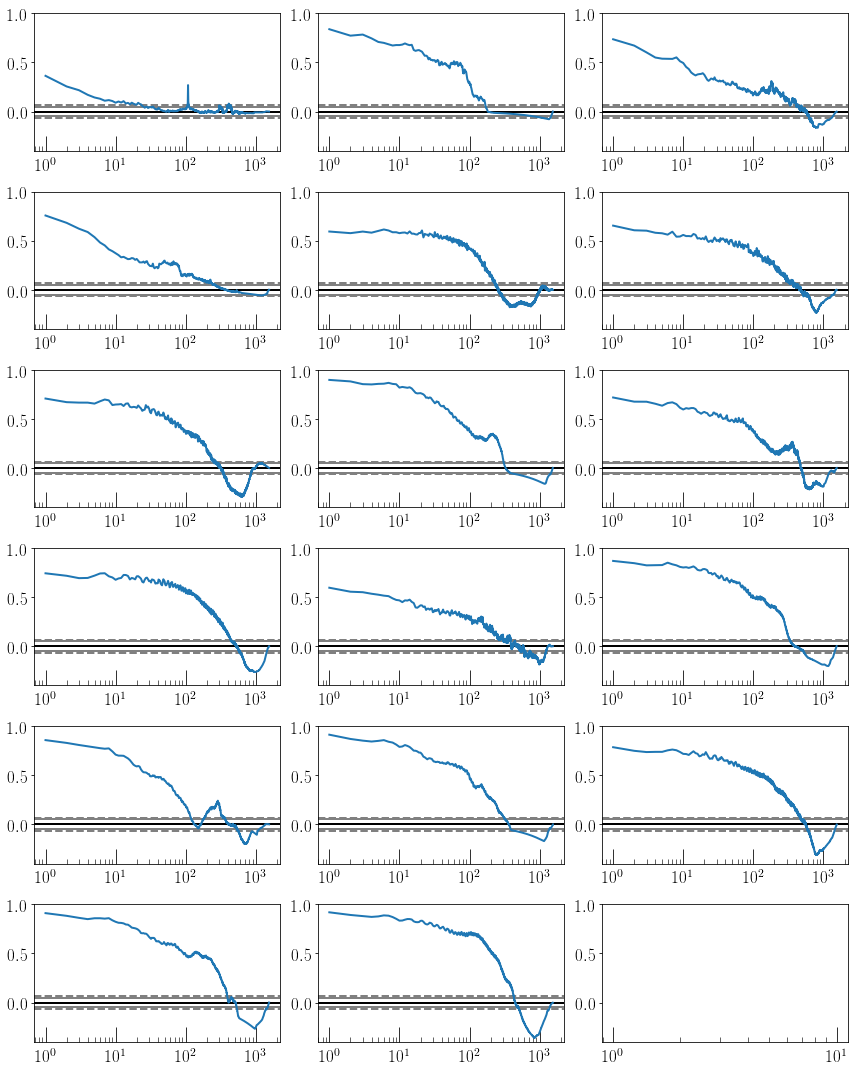

In [81]:
fig,axs = plt.subplots(6, 3, figsize=(12, 15))

for ix,(i,j) in enumerate(itertools.product(range(6), range(3))):
    if ix>16:
        continue
    autocorrelation_plot(data.iloc[:, [ix]], ax=axs[i][j])

for axs_ in axs:
    for ax in axs_:
        ax.set_xscale('log')
        ax.set_ylim(-.4, 1.)
        ax.tick_params(axis='x', which='major', pad=5, length=15, direction='in')
        ax.tick_params(axis='x', which='minor', pad=1, length=5, direction='in')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid(False)

plt.tight_layout()

# t-SNE: dimensionality reduction

In [82]:
data = reviews_df.groupby('app_name').filter(lambda y: y.timetz.count() > 15)\
    .rename(columns={'app_name':'appName'})\
    .groupby(['appName', reviews_df.timetz.dt.round('1D')]).timetz.count()\
    .unstack(level=0).fillna(0)\
    .reindex(columns=reviews_df.groupby('app_name').filter(lambda y: y.timetz.count() > 15)\
                 .groupby('app_name').timetz.count().sort_values(ascending=True).index).T

In [83]:
scaler = StandardScaler()

In [84]:
data_scaled = scaler.fit_transform(data)

In [85]:
tsne = TSNE(random_state=41)

In [86]:
tsne_repr = tsne.fit_transform(data_scaled)

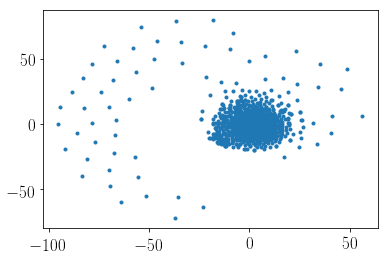

In [87]:
fig,ax = plt.subplots()

ax.scatter(tsne_repr[:, 0], tsne_repr[:, 1])

In [88]:
tsne_acorr = TSNE(random_state=0)

In [89]:
tsne_acorr_repr = tsne_acorr.fit_transform(np.array([signal.correlate(d, d) for d in data.values]))

/home/tonetto/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/home/tonetto/miniconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


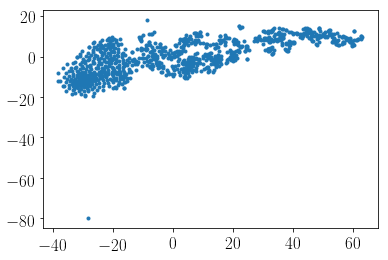

In [90]:
fig,ax = plt.subplots()

ax.scatter(tsne_acorr_repr[:, 0], tsne_acorr_repr[:, 1])

### BIC/AIC to choose number of clusters

Where 8 or 10 look like a good number.

In [99]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(tsne_acorr_repr)
          for n in n_components]

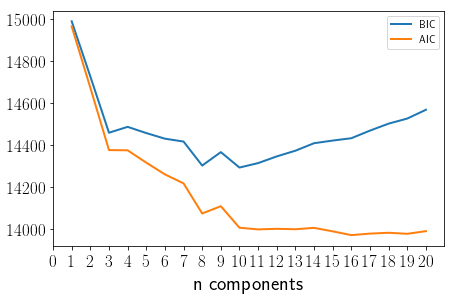

In [100]:
fig,ax = plt.subplots(figsize=(width, height))

ax.plot(n_components, [m.bic(tsne_acorr_repr) for m in models], label='BIC')
ax.plot(n_components, [m.aic(tsne_acorr_repr) for m in models], label='AIC')
ax.legend(loc='best')
ax.set_xlabel('n components')

ax.set_xticks(range(21));

In [101]:
kmeans = KMeans(8, random_state=10)
labels = kmeans.fit(tsne_acorr_repr).predict(tsne_acorr_repr)

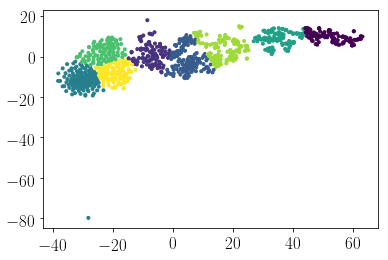

In [102]:
fig,ax = plt.subplots()

ax.scatter(tsne_acorr_repr[:, 0], tsne_acorr_repr[:, 1], c=labels)

In [103]:
plot_indexes = list(itertools.product(range(4), range(2)))

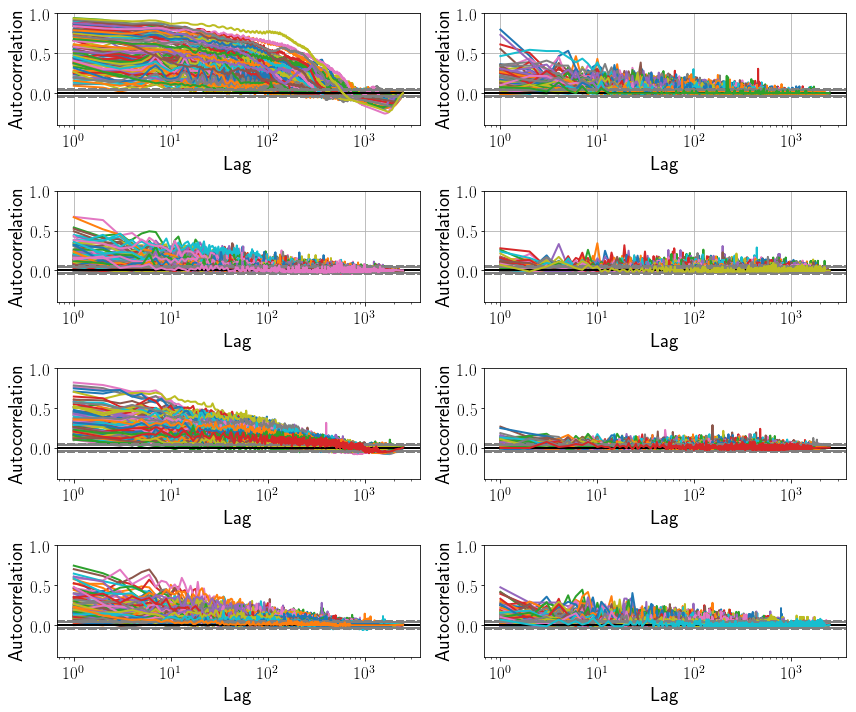

In [104]:
fig,axs = plt.subplots(4,2,figsize=(12,10))

for d, l in zip(data.values, labels):
    i,j = plot_indexes[l]
    autocorrelation_plot(d, ax=axs[i][j])

for axs_ in axs:
    for ax in axs_:
        ax.set_xscale('log')
        ax.set_ylim(-0.4, 1.)

plt.tight_layout()

In [105]:
gmm_model = GaussianMixture(n_components=8, random_state=42)
labels = gmm_model.fit(tsne_acorr_repr).predict(tsne_acorr_repr)

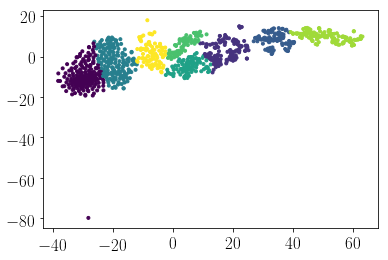

In [106]:
fig,ax = plt.subplots()

ax.scatter(tsne_acorr_repr[:, 0], tsne_acorr_repr[:, 1], c=labels)

In [107]:
plot_indexes = list(itertools.product(range(4), range(2)))

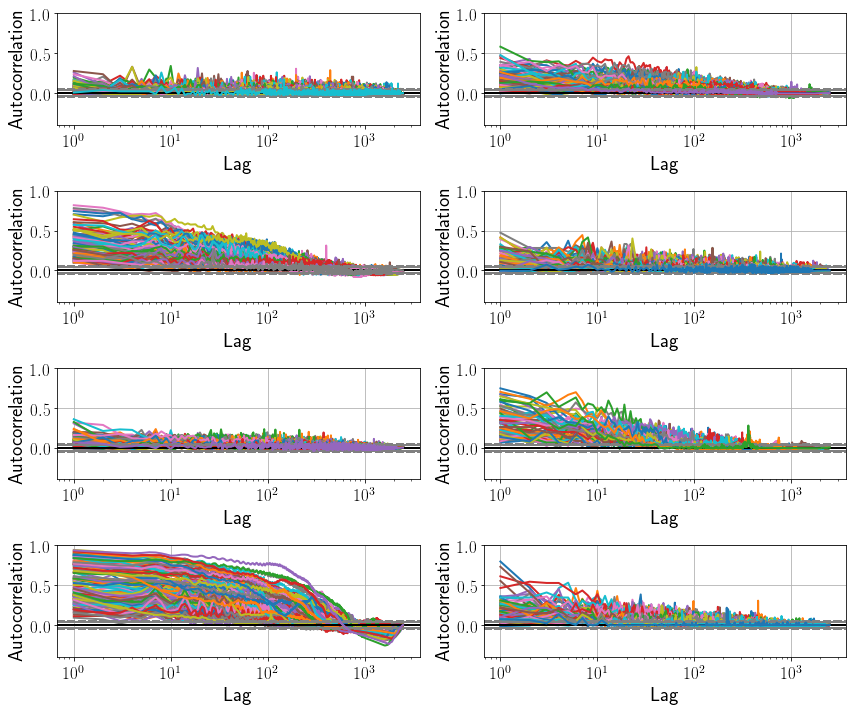

In [108]:
fig,axs = plt.subplots(4,2,figsize=(12,10))

for d, l in zip(data.values, labels):
    i,j = plot_indexes[l]
    autocorrelation_plot(d, ax=axs[i][j])

for axs_ in axs:
    for ax in axs_:
        ax.set_xscale('log')
        ax.set_ylim(-0.4, 1.)

plt.tight_layout()

In [109]:
gmm_model = GaussianMixture(n_components=10, random_state=42)
labels = gmm_model.fit(tsne_acorr_repr).predict(tsne_acorr_repr)

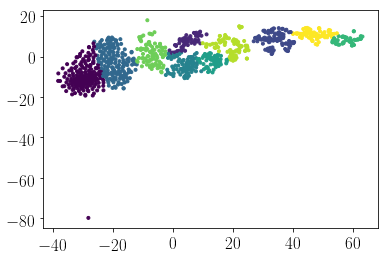

In [110]:
fig,ax = plt.subplots()

ax.scatter(tsne_acorr_repr[:, 0], tsne_acorr_repr[:, 1], c=labels)

In [111]:
plot_indexes_ = list(itertools.product(range(5), range(2)))

In [112]:
plot_indexes = [plot_indexes_[i] for i in [0, 3, 7, 1, 4, 5, 9, 2, 6, 8]]

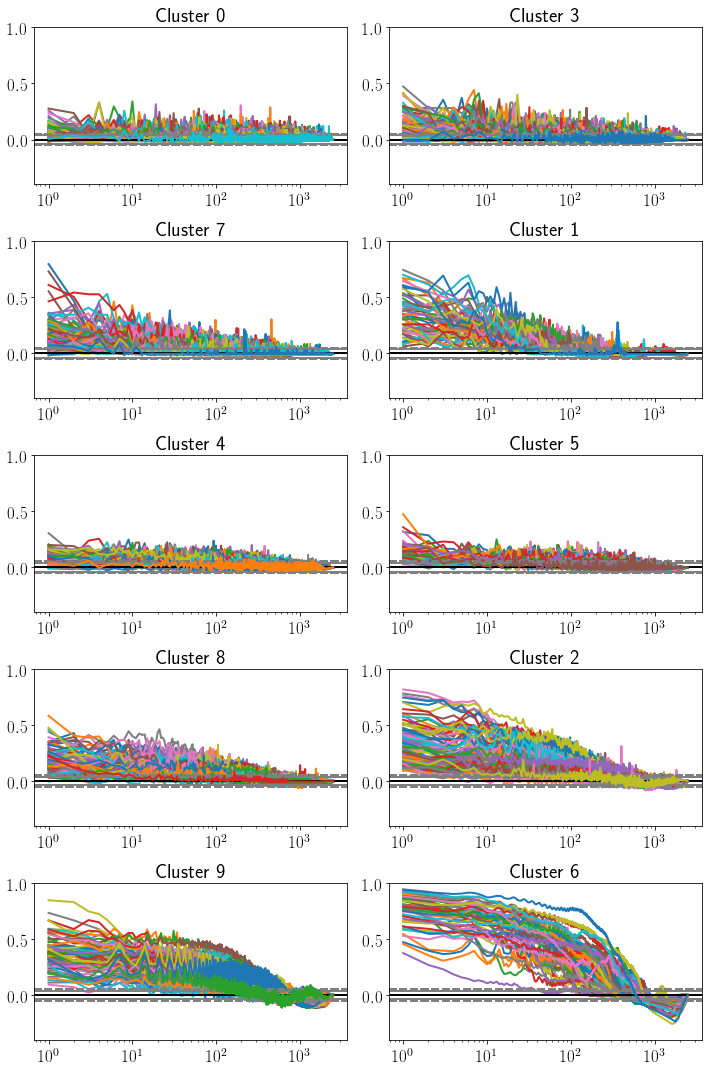

In [113]:
fig,axs = plt.subplots(5,2,figsize=(10,15))

for d, l in zip(data.values, labels):
    i,j = plot_indexes[l]
    autocorrelation_plot(d, ax=axs[i][j])
    axs[i][j].set_title('Cluster {}'.format(l))

for axs_ in axs:
    for ax in axs_:
        ax.set_xscale('log')
        ax.set_ylim(-0.4, 1.)
        ax.grid(False)
        ax.set_ylabel('')
        ax.set_xlabel('')

plt.tight_layout()

I also tried t-SNE down to 3-dimensions, and it found 7 clusters, with one having a single line... didn't look good to me.

----

# Comparing t-SNE clusters

Let's have a look if there are other fundamental differences between these apps in each cluster.

In [120]:
app_label = data.assign(label=labels).label.to_frame()

In [121]:
grouped = reviews_df.groupby('app_name').filter(lambda y: y.timetz.count() > 15)\
    .merge(app_label, on='app_name').groupby(['app_name', 'label']).timetz.count()\
    .reset_index().groupby('label')
df2 = pd.DataFrame({col:vals['timetz'] for col,vals in grouped})
meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]

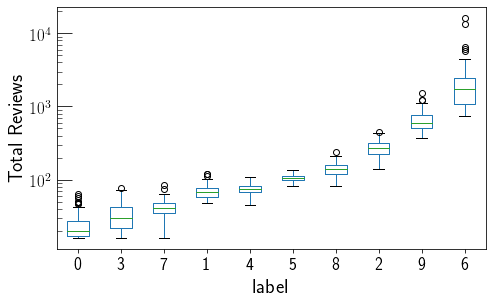

In [123]:
fig,ax = plt.subplots(figsize=(width, height))

df2.boxplot(ax=ax)

ax.set_yscale('log')
ax.set_xlabel('label')
ax.grid(False)

ax.set_ylabel('Total Reviews')

ax.tick_params(axis='y', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='y', which='minor', pad=1, length=5, direction='in')

ax.set_title('')
plt.suptitle('')

plt.tight_layout()

In [124]:
grouped = reviews_df.merge(app_label, on='app_name')\
    .assign(tdiff=lambda x: x.groupby('app_name').timetz.diff().dt.total_seconds().astype(np.float))\
    .groupby('label')

df2 = pd.DataFrame({col:vals['tdiff'] for col,vals in grouped})
df2 = df2[meds.index]

Something is very *fishy* about this last cluster.

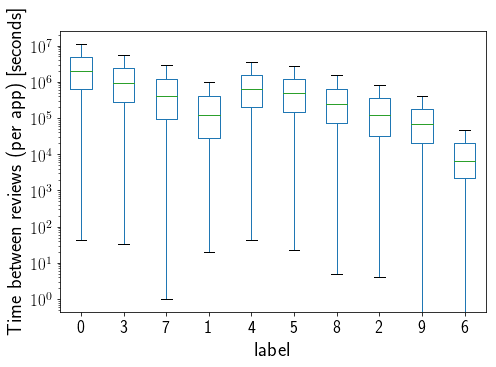

In [125]:
fig,ax = plt.subplots(figsize=(width, 1.2*height))

df2.boxplot(ax=ax, showfliers=False)


ax.set_xlabel('label')
ax.grid(False)
ax.set_title('')
ax.set_yscale('log')

ax.set_ylabel('Time between reviews (per app) [seconds]')

plt.suptitle('')
plt.tight_layout()

Number of apps pler cluster:

In [129]:
data = reviews_df.merge(app_label, on='app_name')\
                    .assign(tdiff=lambda x: x.groupby('app_name').timetz.diff().dt.total_seconds().astype(np.float))

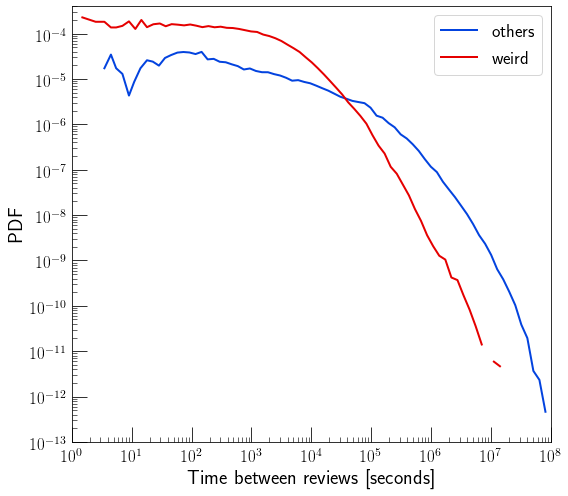

In [130]:
fig,ax = plt.subplots(figsize=(8, 7))

powerlaw.plot_pdf(data[(data.tdiff>0)&(data.label!=6)].tdiff, label='others', ax=ax,
                      c='xkcd:blue')
powerlaw.plot_pdf(data[(data.tdiff>0)&(data.label==6)].tdiff, label='weird', ax=ax,
                      c='xkcd:red')

ax.set_ylim(1e-13, 4e-4)

ax.legend()
ax.set_xlim(1e0, 1e8)
ax.set_xlabel('Time between reviews [seconds]')
ax.set_ylabel('PDF')
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='both', which='minor', pad=1, length=5, direction='in')

plt.tight_layout()

In [133]:
reviews_per_app = pd.concat([reviews_df.merge(app_label, on='app_name')\
            .groupby('label').author_name.nunique().rename('total'),
           reviews_df.merge(app_label, on='app_name')\
            .groupby('author_name').filter(lambda x: x.timetz.count()==1)\
            .groupby('label').author_name.nunique().rename('single')], axis=1)

Text(0,0.5,'Fract. single-review authors')

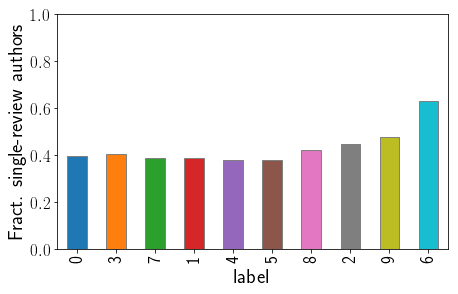

In [135]:
fig,ax = plt.subplots(figsize=(width, height))

cmap = plt.get_cmap('tab10')

reviews_per_app.reindex(index=meds.index).assign(sratio=lambda y: y.single/y.total).sratio\
    .plot(kind='bar', ax=ax, stacked=True, color=cmap(range(10)), edgecolor='grey')

ax.set_ylim(0, 1)
ax.set_xlabel('label')
ax.set_ylabel('Fract. single-review authors')

In [136]:
reviewLen_per_app = pd.concat([reviews_df.merge(app_label, on='app_name')\
                        .groupby('label').author_name.nunique().rename('total'),
                               reviews_df.merge(app_label, on='app_name')\
                        .pipe(lambda y: y[y.reviewLen==0])\
                        .groupby('label').author_name.nunique().rename('empty')], axis=1).fillna(0)\
    .assign(er=lambda y: y['empty']/y['total'])

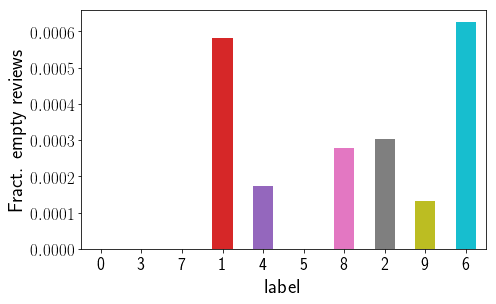

In [137]:
fig,ax = plt.subplots(figsize=(width, height))

reviewLen_per_app.reindex(index=meds.index)['er'].plot(kind='bar', ax=ax, rot=0)
ax.set_ylabel('Fract. empty reviews')
ax.set_xlabel('label')

plt.tight_layout()

Look at distribution of posts per user from each of these clusters:

    * Message length
    * Stars

In [138]:
grouped = reviews_df.merge(app_label, on='app_name')\
    .groupby('label')

df2 = pd.DataFrame({col:vals['reviewLen'] for col,vals in grouped})
df2 = df2[meds.index]

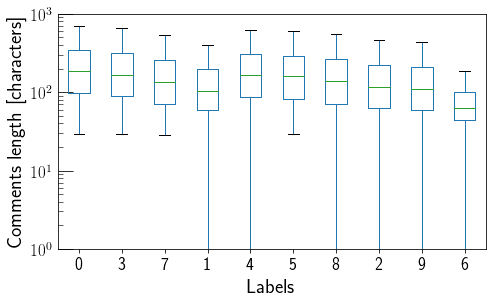

In [140]:
fig,ax = plt.subplots(figsize=(width, height))

df2.boxplot(ax=ax, grid=False, showfliers=False)

ax.set_yscale('log')

ax.set_ylim(1e0, 1e3)

ax.tick_params(axis='y', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='y', which='minor', pad=1, length=5, direction='in')

ax.set_ylabel('Comments length [characters]')
ax.set_xlabel('Labels')

ax.set_title('')
plt.suptitle('')

plt.tight_layout()

In [141]:
ps_ = pd.cut(reviews_df.merge(app_label, on='app_name').reviewLen, bins=np.linspace(1, 5000, num=25),
       labels=np.linspace(1, 5000, num=25)[:-1],
       retbins=True)

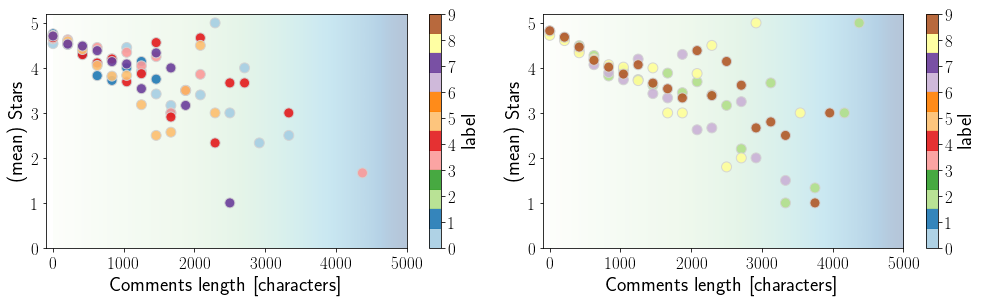

In [142]:
fig,axs = plt.subplots(1,2,figsize=(2*width, height))

gradient = reviews_df.merge(app_label, on='app_name').reviewLen.quantile(q=np.arange(0, 1.01, 0.05))\
    .apply(np.log10)\
    .values[1:-1].reshape(1, -1)

# gradient = np.stack([reviews_df.merge(app_label, on='app_name').reviewLen.quantile(q=np.arange(0, 1.01, 0.05))\
#     .apply(np.log10)\
#     .values[1:-1],
#           reviews_df.merge(app_label, on='app_name').reviewLen.quantile(q=np.arange(0, 1.01, 0.05))\
#     .apply(np.log10)\
#     .values[1:-1]], axis=1)

# gradient = [(0,0,1), (0,1,2), (0,2,3), (0,3,4)]

# gradient = np.array([(0,  0,    0,   0,    0),
#                      (0,  0.25, 0.5, 0.25, 0),
#                      (0,  0.5,  1,   0.5,  0),
#                      (0,  0.25, 0.5, 0.25, 0),
#                      (0,  0,    0,   0,    0)])
# gradient = - gradient

for ax in axs:
    ax.imshow(gradient, extent=(0, 5000, 0, 5.2), aspect='auto', cmap='GnBu',
              interpolation='bicubic', alpha=0.3)

data = reviews_df.merge(app_label, on='app_name')\
    .groupby([ps_[0], 'label']).stars.agg(['mean','median','std']).dropna().reset_index()\
    .assign(revLen=lambda y: pd.to_numeric(y.reviewLen))\
    .assign(relabel=lambda y: y.label.map({v:ix for ix,v in enumerate(list(meds.index))}))

data[data.relabel<=5]\
    .plot.scatter('revLen', 'mean', ax=axs[0], s=100, c='label', cmap='Paired',
                  alpha=0.9, edgecolor='lightgrey', zorder=3, vmin=0, vmax=9)

data[data.relabel>5]\
    .plot.scatter('revLen', 'mean', ax=axs[1], s=100, c='label', cmap='Paired',
                  alpha=0.9, edgecolor='lightgrey', zorder=3, vmin=0, vmax=9)

for ax in axs:
    ax.set_ylim(0, 5.2)
    ax.set_xlim(-100, 5000)
    ax.set_ylabel('(mean) Stars')
    ax.set_xlabel('Comments length [characters]')

plt.tight_layout()

# Response after a bad review

In [143]:
data = reviews_df[reviews_df.stars<4].merge(app_label, on='app_name')\
    .groupby(['label', 'stars', 'app_name']).timetz.count().unstack(level=[0, 1])\
    .stack().stack().rename('value').reset_index()

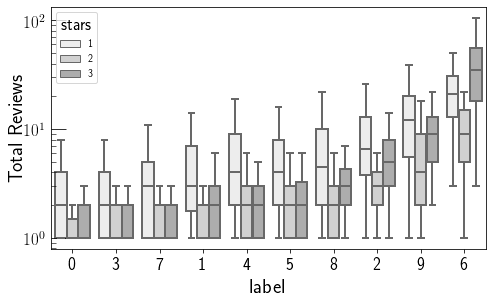

In [144]:
fig,ax = plt.subplots(figsize=(width, height))

sns.set_palette("Greys")

sns.boxplot(x='label', y='value', hue='stars', data=data,
            ax=ax, showfliers=False, order=list(meds.index))

ax.tick_params(axis='y', which='major', pad=5, length=15, direction='in')
ax.tick_params(axis='y', which='minor', pad=1, length=5, direction='in')

ax.set_yscale('log')
ax.set_ylabel('Total Reviews', labelpad=-2)

plt.tight_layout()

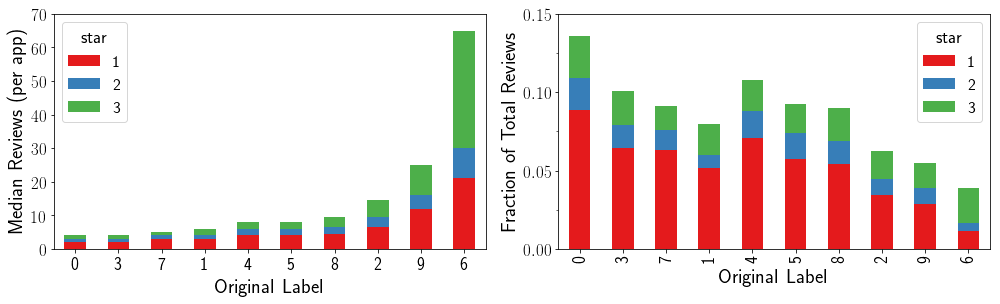

In [145]:
fig,axs = plt.subplots(1,2,figsize=(2*width, height))

sns.set_palette("Set1")

reviews_df[reviews_df.stars<4].merge(app_label, on='app_name')\
    .groupby(['label', 'stars', 'app_name']).timetz.count().unstack(level=[0, 1])\
    .median(axis=0).unstack(level=0).reindex(columns=meds.index).T\
    .plot.bar(stacked=True, ax=axs[0], rot=0)
axs[0].set_ylabel('Median Reviews (per app)')
axs[0].set_ylim(0, 70)
axs[0].set_yticks(range(0, 71, 10))

reviews_df.merge(app_label, on='app_name').groupby(['label', 'stars']).timetz.count().unstack(level=1)\
    .pipe(lambda y: y.div(y.sum(axis=1), axis=0)).reindex(index=list(meds.index))[[1, 2, 3]]\
    .plot.bar(stacked=True, ax=axs[1])
axs[1].set_ylabel('Fraction of Total Reviews')
axs[1].set_ylim(0, 0.15)
axs[1].set_yticks(np.arange(0, 0.16, 0.05), minor=False)
axs[1].set_yticks(np.arange(0.025, 0.16, 0.05), minor=True)

for ax in axs:
    ax.set_xlabel('Original Label')
    L=ax.legend(fontsize=16, title='star')
    L.get_title().set_fontsize(18)

plt.tight_layout()

In [149]:
reviews_labeled_df = reviews_df.merge(app_label, on='app_name')

In [150]:
len(reviews_df[reviews_df.stars<4].index)/len(reviews_df.index)

0.05799325430481864

In [151]:
df_ = {3:[], 7:[], 14:[], 28:[]}
for name,grp in reviews_labeled_df.groupby('app_name'):
    diffmx = pd.concat([pd.Series(grp.index).rename('idx'),
           pd.DataFrame((grp['timetz'].values - grp['timetz'].values[:, None]).astype(np.float)//1e9, columns=grp.index)],
          axis=1).set_index('idx').pipe(lambda y: y[y>=0])
    for d in [3, 7, 14, 28]:
        df_[d].append(pd.concat([diffmx[grp[grp.stars==s].index].pipe(lambda y: y[y<(d*86400)]).mean(axis=1).rename('S{}'.format(s)) for s in range(1, 6)], axis=1))

/home/tonetto/miniconda3/lib/python3.6/site-packages/pandas/core/nanops.py:358: RuntimeWarning: divide by zero encountered in true_divide
  the_mean = the_sum / count


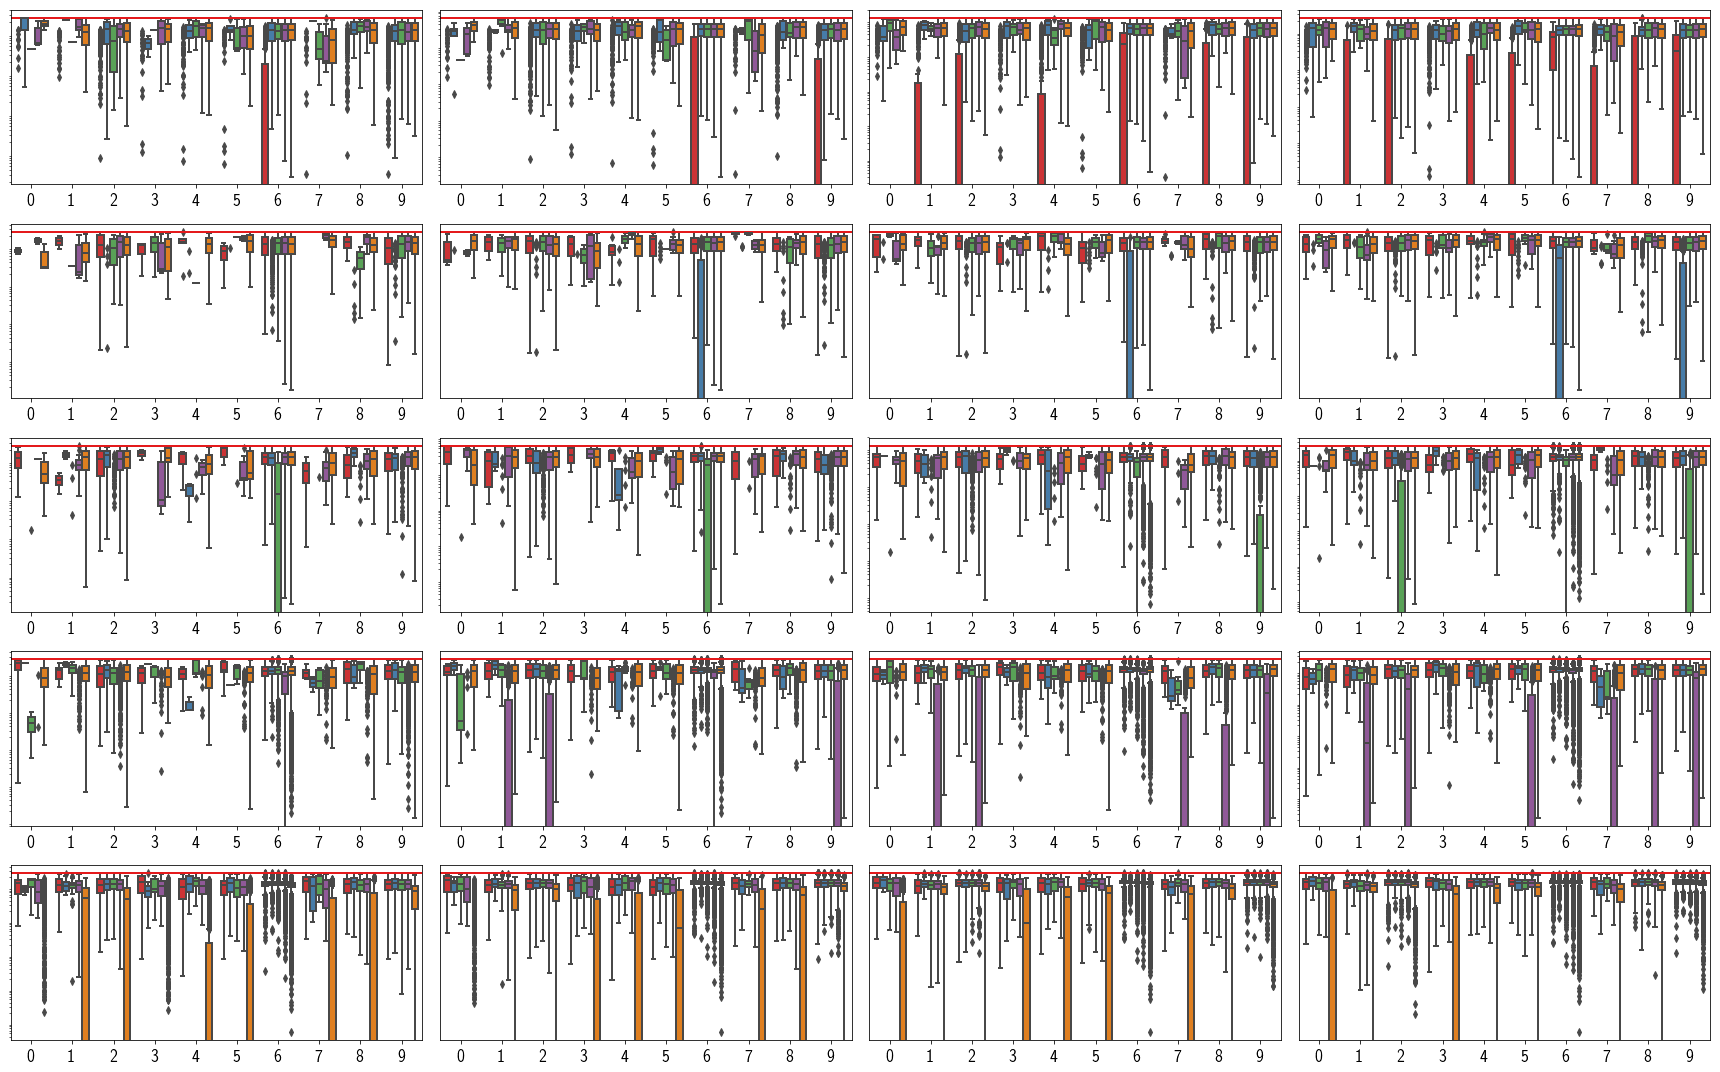

In [152]:
fig,axs = plt.subplots(5,4, figsize=(24, 15))

for i,d in enumerate([3, 7, 14, 28]):
    for j in range(5):
        sns.boxplot(x='label',
                    y='S{}'.format(j+1),
                    hue='stars',
                    data=reviews_labeled_df.merge(pd.concat(df_[d], axis=0).sort_index(),
                                                  right_index=True,
                                                  left_index=True),
                    ax=axs[j][i])
        axs[j][i].axhline(d*86400)

for axs_ in axs:
    for ax in axs_:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.legend().remove()
        ax.set_yscale('log')
        ax.set_yticks(())

plt.tight_layout()

# Timeseries with Prophet

In [153]:
from fbprophet import Prophet

In [154]:
example_df = reviews_df.groupby(reviews_df.timetz.dt.round('1D')).timetz.count().rename('y').reset_index()\
    .rename(columns={'timetz':'ds'})

In [155]:
m = Prophet()

In [156]:
m.fit(example_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/tonetto/miniconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


I call predict without any parameter to get an in-sample fit of my historical data.

In [157]:
forecast = m.predict()

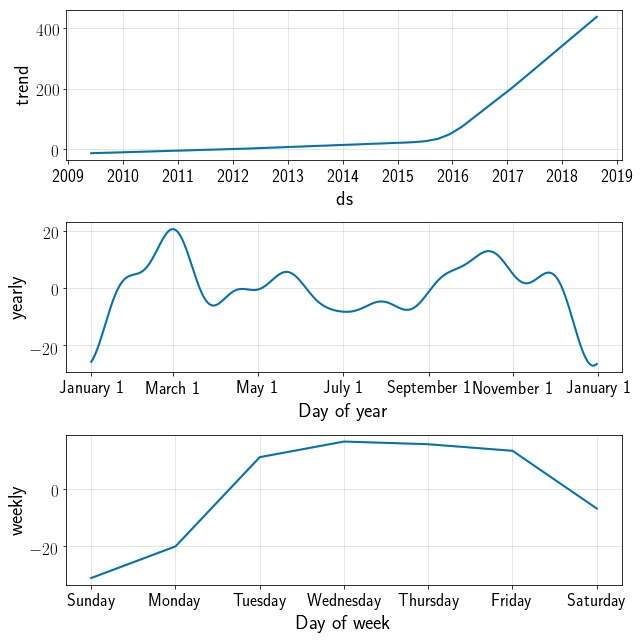

In [158]:
m.plot_components(forecast);

Splitting between the clusters, the *special* ones actually dictate most of the yearly seasonality, which is really strange, imo.

In [159]:
example_df = reviews_labeled_df[(reviews_labeled_df.label!=6)&\
                                (reviews_labeled_df.label!=9)&\
                                (reviews_labeled_df.label!=8)&\
                                (reviews_labeled_df.label!=2)]\
    .groupby(reviews_labeled_df[(reviews_labeled_df.label!=6)&\
                                (reviews_labeled_df.label!=9)&\
                                (reviews_labeled_df.label!=8)&\
                                (reviews_labeled_df.label!=2)].timetz.dt.round('1D'))\
    .timetz.count().rename('y').reset_index()\
    .rename(columns={'timetz':'ds'})

m = Prophet()
m.fit(example_df)
forecast = m.predict()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/tonetto/miniconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


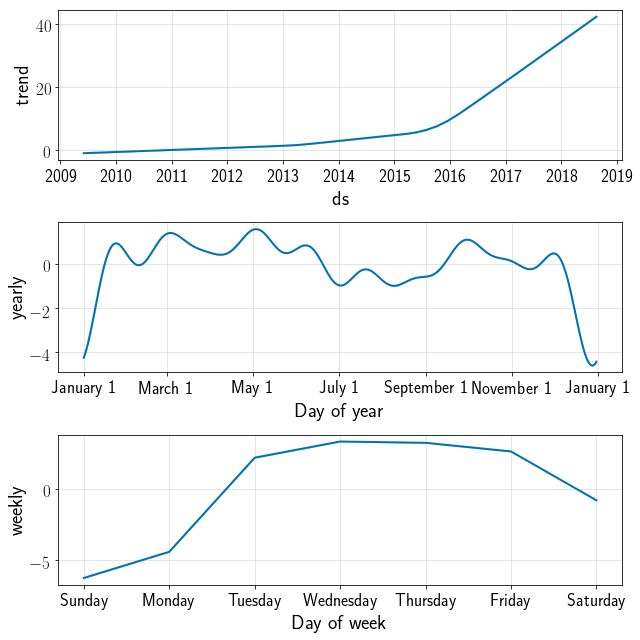

In [160]:
m.plot_components(forecast);

In [161]:
example_df = reviews_labeled_df[(reviews_labeled_df.label==6)|\
                                (reviews_labeled_df.label==9)|\
                                (reviews_labeled_df.label==8)|\
                                (reviews_labeled_df.label==2)]\
    .groupby(reviews_labeled_df[(reviews_labeled_df.label==6)|\
                                (reviews_labeled_df.label==9)|\
                                (reviews_labeled_df.label==8)|\
                                (reviews_labeled_df.label==2)].timetz.dt.round('1D'))\
    .timetz.count().rename('y').reset_index()\
    .rename(columns={'timetz':'ds'})

m = Prophet()
m.fit(example_df)
forecast = m.predict()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/tonetto/miniconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


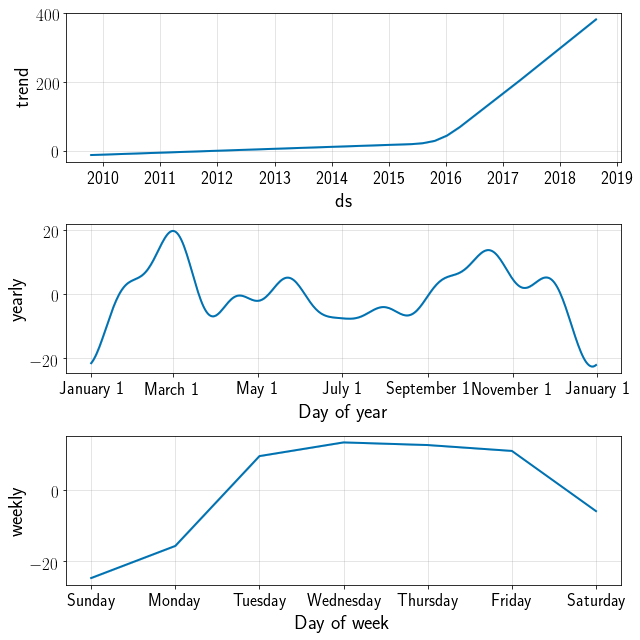

In [162]:
m.plot_components(forecast);

# h-index

In [163]:
# gotta consider ALL authors
author_nrevs = reviews_df.groupby('author_name').timetz.count().rename('author_nrevs')\
    .sort_values().to_frame()\
    .reset_index()

In [164]:
l_index = reviews_labeled_df.merge(author_nrevs, on='author_name')\
    .groupby(['app_name', 'label', 'author_nrevs']).timetz.count().rename('rev_l').reset_index()\
    .pipe(lambda y: y[y.rev_l >= y.author_nrevs])\
    .pipe(lambda y: y.loc[y.groupby('app_name')['author_nrevs'].idxmax()])[['app_name', 'label', 'author_nrevs']]\
    .rename(columns={'author_nrevs':'l-index'})

In [165]:
l_index.head()

app_name  label  l-index
3    Cozy Image Gallery + Free Video Gallery      1        4
12           RetailtowerPro - Shopping Feeds      3        3
29                                3-Products      1        4
48                            AMP by FireAMP      1        4
72                       AMP by Shop Sheriff      1        3

(0, 20)

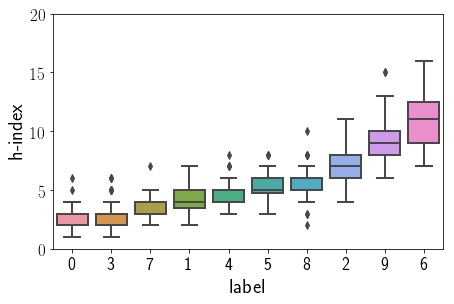

In [168]:
fig,ax = plt.subplots(figsize=(width, height))

sns.set_palette('RdYlBu_r')

sns.boxplot(x='label', y='l-index', data=l_index, order=list(meds.index))

ax.set_ylabel('h-index')

ax.set_ylim(0, 20)

# Shared reviewers

This looks into the number of reviewers shared among apps also building a network based on these numbers. This graph could be interpreted as how *central* apps are with respect to others in the network.

In [169]:
shared_reviewers = reviews_df.merge(reviews_df[['app_name', 'author_name']], on='author_name')\
    .pipe(lambda y: y[y.app_name_y != y.app_name_x])\
    .groupby(['app_name_x', 'app_name_y']).timetz.count().rename('sharedreviewers')\
    .unstack(level=0)

In [170]:
shrdrevs = shared_reviewers.sum(axis=1).rename('sharedrevs').to_frame().merge(reviews_labeled_df[['app_name', 'label']].drop_duplicates().set_index('app_name'),
                                              left_index=True, right_index=True)

In [171]:
shrdrevs.head()

sharedrevs  label
 Cozy Image Gallery + Free Video Gallery        99.0      1
 RetailtowerPro - Shopping Feeds               347.0      3
3-Products                                     305.0      1
AMP by FireAMP                                 716.0      1
AMP by Shop Sheriff                            201.0      1

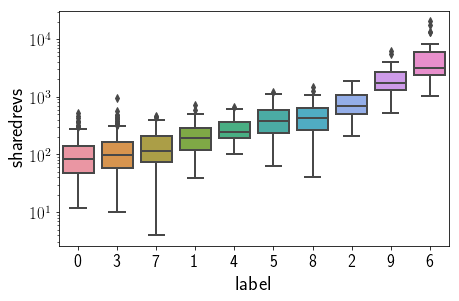

In [172]:
fig,ax = plt.subplots(figsize=(width, height))

sns.boxplot(x='label', y='sharedrevs', data=shrdrevs,
            ax=ax, order=list(meds.index))

ax.set_yscale('log')

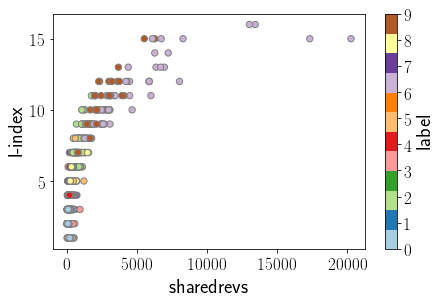

In [173]:
fig,ax = plt.subplots(figsize=(width, height))

l_index.merge(shrdrevs['sharedrevs'].to_frame(), left_on='app_name', right_index=True)\
    .plot.scatter(x='sharedrevs', y='l-index', c='label',ax=ax, cmap='Paired', s=40, edgecolor='grey')

In [174]:
l_index.merge(shrdrevs, left_on='app_name', right_index=True).head()

app_name  label_x  l-index  sharedrevs  \
3    Cozy Image Gallery + Free Video Gallery        1        4        99.0   
12           RetailtowerPro - Shopping Feeds        3        3       347.0   
29                                3-Products        1        4       305.0   
48                            AMP by FireAMP        1        4       716.0   
72                       AMP by Shop Sheriff        1        3       201.0   

    label_y  
3         1  
12        3  
29        1  
48        1  
72        1

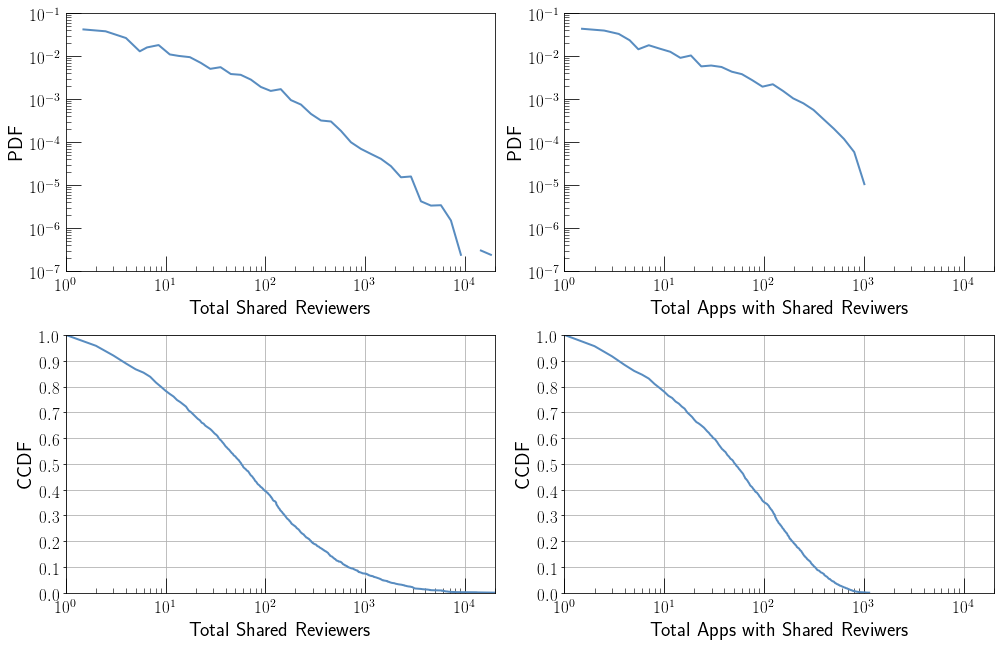

In [175]:
fig,axs = plt.subplots(2,2,figsize=(2*width, 2.1*height))

sns.set_palette('Blues_r')

powerlaw.plot_pdf(shared_reviewers.sum(axis=1), ax=axs[0][0])
powerlaw.plot_pdf((shared_reviewers.fillna(0) != 0).sum(axis=0).sort_values(), ax=axs[0][1])

for ax in axs[0]:
    ax.set_ylabel('PDF')
    ax.set_ylim(1e-7, 1e-1)
    ax.tick_params(axis='both', which='major', pad=5, length=15, direction='in')
    ax.tick_params(axis='both', which='minor', pad=1, length=5, direction='in')
axs[0][0].set_xlabel('Total Shared Reviewers')
axs[0][1].set_xlabel('Total Apps with Shared Reviwers')


powerlaw.plot_ccdf(shared_reviewers.sum(axis=1), ax=axs[1][0])
powerlaw.plot_ccdf((shared_reviewers.fillna(0) != 0).sum(axis=0).sort_values(), ax=axs[1][1])

for ax in axs[1]:
    ax.set_ylabel('CCDF')
    ax.set_yscale('linear')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.tick_params(axis='x', which='major', pad=5, length=15, direction='in')
    ax.tick_params(axis='x', which='minor', pad=1, length=5, direction='in')
    ax.grid()
axs[1][0].set_xlabel('Total Shared Reviewers')
axs[1][1].set_xlabel('Total Apps with Shared Reviwers')

for axs_ in axs:
    for ax in axs_:
        ax.set_xlim(1e0, 2e4)

plt.tight_layout()

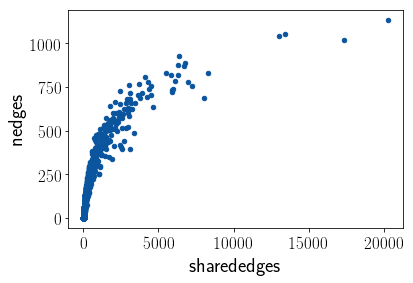

In [176]:
pd.concat([shared_reviewers.sum(axis=1).rename('sharededges'),
           (shared_reviewers.fillna(0) != 0).sum(axis=0).rename('nedges')], axis=1)\
    .plot.scatter('sharededges', 'nedges')

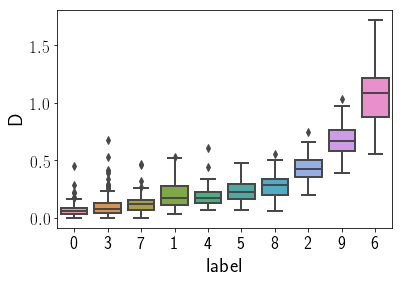

In [177]:
data = pd.concat([(shared_reviewers.fillna(0) != 0).apply(entropy).rename('Smax'),
           shared_reviewers.fillna(0).apply(entropy).rename('Sunc')], axis=1)\
    .assign(D=lambda y: y.Smax - y.Sunc).rename(index={'app_name_x':'app_name'})\
    .merge(app_label, left_index=True, right_index=True)

sns.boxplot(x='label', y='D', data=data, order=meds.index)

In [178]:
G = nx.from_numpy_matrix(~shared_reviewers.isna().values)

In [179]:
revs_closeness_centrality = nx.centrality.closeness_centrality(G)

In [180]:
revs_eigenvector_centrality = nx.centrality.eigenvector_centrality(G)

In [181]:
revs_betweenness_centrality = nx.centrality.betweenness_centrality(G)

In [182]:
revs_katz_centrality = nx.centrality.katz_centrality_numpy(G)

In [183]:
revs_subgraph_centrality = nx.centrality.subgraph_centrality(G)

In [184]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
Gcc = sorted([G.subgraph(c).copy() for c in nx.connected_components(G)], key = len, reverse=True)[0]
pos = nx.spring_layout(Gcc, k=1/2)

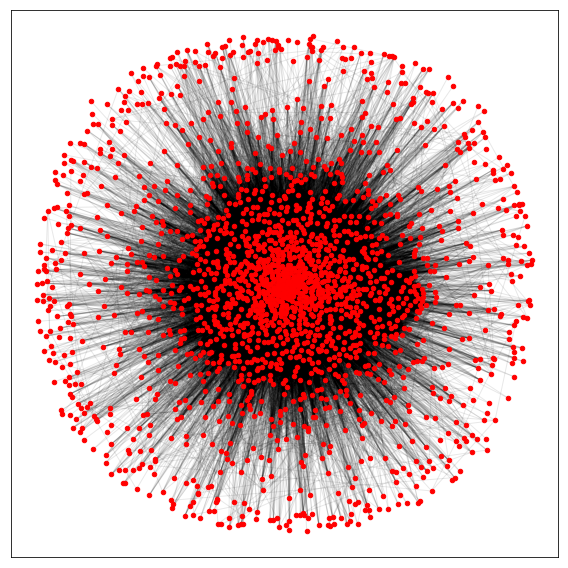

In [187]:
fig,ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx_nodes(Gcc, pos, node_size=20, ax=ax)
nx.draw_networkx_edges(Gcc, pos, alpha=0.09, ax=ax)

ax.set_yticks([])
ax.set_xticks([]);

plt.tight_layout()

In [188]:
def char_range(c1, c2):
    """Generates the characters from `c1` to `c2`, inclusive."""
    for c in range(ord(c1), ord(c2)+1):
        yield chr(c)

In [189]:
list(meds.index)

[0, 3, 7, 1, 4, 5, 8, 2, 9, 6]

In [190]:
char_lists = {ix:'{}.{}'.format(c, ix) for ix,c in zip(meds.index, char_range('a', 'l'))}

In [191]:
['{}.{}'.format(c, ix) for ix,c in zip(meds.index, char_range('a', 'l'))]

['a.0', 'b.3', 'c.7', 'd.1', 'e.4', 'f.5', 'g.8', 'h.2', 'i.9', 'j.6']

In [192]:
centralities = pd.DataFrame({'closeness':revs_closeness_centrality,
              'eigenvector':revs_eigenvector_centrality,
              'betweenness':revs_betweenness_centrality,
              'katz':revs_katz_centrality,
              'app_name':{ix:a for ix,a in enumerate(shared_reviewers.index)}})\
    .merge(app_label, on='app_name')

In [193]:
centralities['labels'] = centralities.label.apply(lambda y: char_lists[y])

In [194]:
centralities.head()

closeness  eigenvector  betweenness      katz  \
0   0.483700     0.011870     0.000050 -0.006152   
1   0.512902     0.032630     0.000217  0.055537   
2   0.503931     0.024226     0.000348  0.042909   
3   0.548719     0.050294     0.002064 -0.029913   
4   0.498873     0.020033     0.000095  0.019484   

                                   app_name  label labels  
0   Cozy Image Gallery + Free Video Gallery      1    d.1  
1           RetailtowerPro - Shopping Feeds      3    b.3  
2                                3-Products      1    d.1  
3                            AMP by FireAMP      1    d.1  
4                       AMP by Shop Sheriff      1    d.1

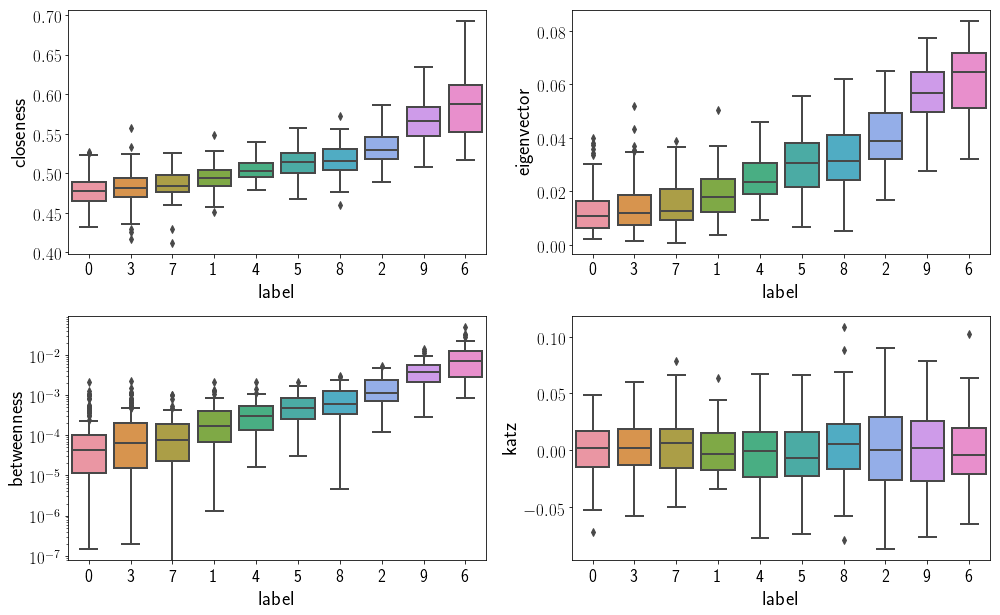

In [195]:
fig,axs = plt.subplots(2,2,figsize=(2*width, 2*height))

sns.boxplot(y='closeness', x='label', data=centralities, order=meds.index, ax=axs[0][0])
sns.boxplot(y='eigenvector', x='label', data=centralities, order=meds.index, ax=axs[0][1])
sns.boxplot(y='betweenness', x='label', data=centralities, order=meds.index, ax=axs[1][0])
axs[1][0].set_yscale('log')
sns.boxplot(y='katz', x='label', data=centralities, order=meds.index, ax=axs[1][1])

plt.tight_layout()

/home/tonetto/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


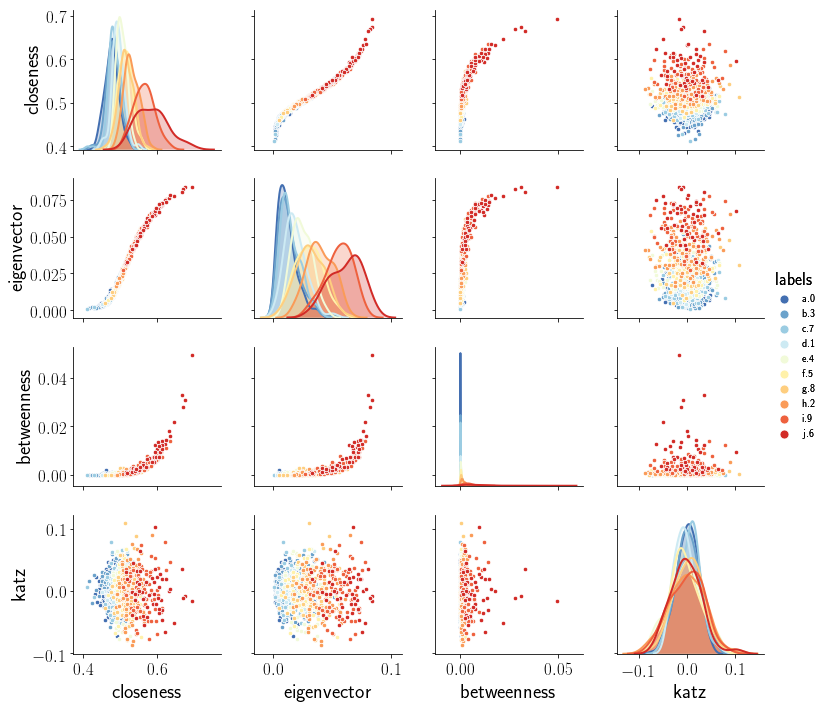

In [196]:
g = sns.pairplot(centralities.drop(columns=('label')), hue='labels', plot_kws={"s": 20}, palette='RdYlBu_r',
                 hue_order=['{}.{}'.format(c, ix) for ix,c in zip(meds.index, char_range('a', 'l'))])

g.add_legend(markerscale=2)

## (Cosine) Similarity

In [197]:
app_nrevs=reviews_df.groupby('app_name').timetz.count().rename('nrevs')

In [198]:
cossim = reviews_df.merge(reviews_df[['app_name', 'author_name']], on='author_name')\
    .pipe(lambda y: y[y.app_name_y != y.app_name_x])\
    .groupby(['app_name_x', 'app_name_y']).timetz.count().rename('sharedreviewers').reset_index()

In [199]:
cossim['similarity'] = cossim.apply(lambda y: y.sharedreviewers/(app_nrevs[y.app_name_x]*app_nrevs[y.app_name_y]),axis=1)

In [200]:
cossim.drop(columns=['sharedreviewers'], inplace=True)

In [201]:
csim = cossim\
    .merge(app_label, left_on='app_name_x', right_on='app_name').rename(columns={'label':'labelX'})\
    .merge(app_label, left_on='app_name_y', right_on='app_name').rename(columns={'label':'labelY'})

The lower the *cosine* similarity, the closer elements of these groups are. From the next plot, cluster no. 6 shared great similarity with apps from other groups. One interpretation of this is that, several authors who reviwed app in cluster 6 also reviewed several others, but I guess that's somewhat expected.

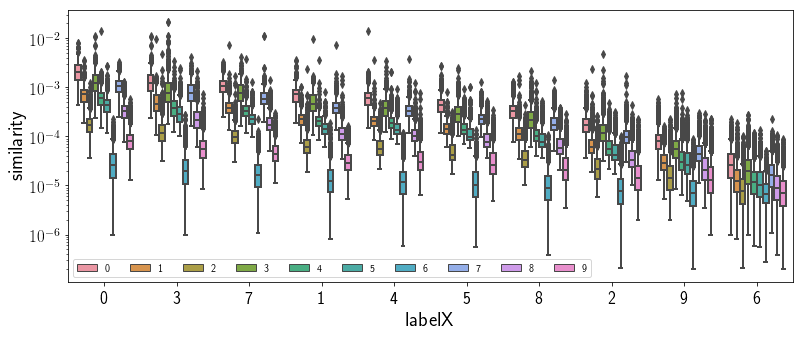

In [203]:
fig,ax = plt.subplots(figsize=(13, 5))

sns.boxplot(x='labelX', y='similarity', hue='labelY', data=csim, ax=ax, order=meds.index)
ax.set_yscale('log')
ax.legend(ncol=10)

# Toeplitz Inverse Covariance-based Clustering

From [1]

    TICC learns both the cluster Markov Random Fields (MRFs) and the time series segmentation.

[1] Hallac, David, et al. "Toeplitz inverse covariance-based clustering of multivariate time series data." Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. ACM, 2017. https://doi.org/10.1145/3097983.3098060

Note: I tried running their code on a separate notebook but couldn't get anything really good. Maybe data is too sparse for their algorithms to work well.

In [204]:
print('Sparsity (?): {}'.format(reviews_labeled_df.groupby(['app_name',
                            reviews_labeled_df[reviews_labeled_df.label==6].timetz.dt.round('1h')])\
    .timetz.count().unstack(level=0).isnull().sum().div(len(reviews_labeled_df.groupby(['app_name',
                            reviews_labeled_df[reviews_labeled_df.label==6].timetz.dt.round('1h')])\
    .timetz.count().unstack(level=0).index))\
    .sort_values().mean()))

Sparsity (?): 0.9126952730526108


In [205]:
ts_topcluster = reviews_labeled_df.groupby(['app_name',
                            reviews_labeled_df[reviews_labeled_df.label==6].timetz.dt.round('1h')])\
    .timetz.count().unstack(level=0).fillna(0)

In [206]:
#ts_topcluster.values
np.savetxt('c6.csv', ts_topcluster.values, delimiter=',')

In [207]:
len(reviews_labeled_df.groupby(['app_name',
                            reviews_labeled_df[reviews_labeled_df.label==6].timetz.dt.round('1h')])\
    .timetz.count().unstack(level=0).index)

23494